In [1]:
import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150,facecolor='white')

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
adata = sc.read("PBMC.h5ad")

# Process Data

In [3]:
dataset = GeneVectorDataset(adata)

Loading Expression.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1051348/1051348 [00:01<00:00, 1011618.68it/s]


Reindexing Cooc


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14039/14039 [00:00<00:00, 61787.54it/s]


# Setup Model

In [4]:
retrain = True
if retrain:
    cmps = GeneVector(dataset,
                      output_file="pbmc_nextgenX.vec",
                      emb_dimension=100,
                      c=1000.,
                      batch_size=10000000)
    cmps.train(1000,threshold=1e-8)
    cmps.plot()
    embed = GeneEmbedding("pbmc_nextgenX.vec", dataset, vector="average")
else:
    embed = GeneEmbedding("embeddings/pbmc_nextgen.vec", dataset, vector="average")

# Compute Similar Genes to IFIT1

In [8]:
embed.compute_similarities("IFIT1")[:10]

Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3379777.60it/s]

      Gene  Similarity
0    IFIT1    1.000000
1    IFIT3    0.948210
2     LY6E    0.917732
3    ISG15    0.905736
4     OAS1    0.889833
5  TNFSF10    0.888145
6      MX1    0.877636
7    ISG20    0.870480
8     LAP3    0.797675
9   SAMD9L    0.786614


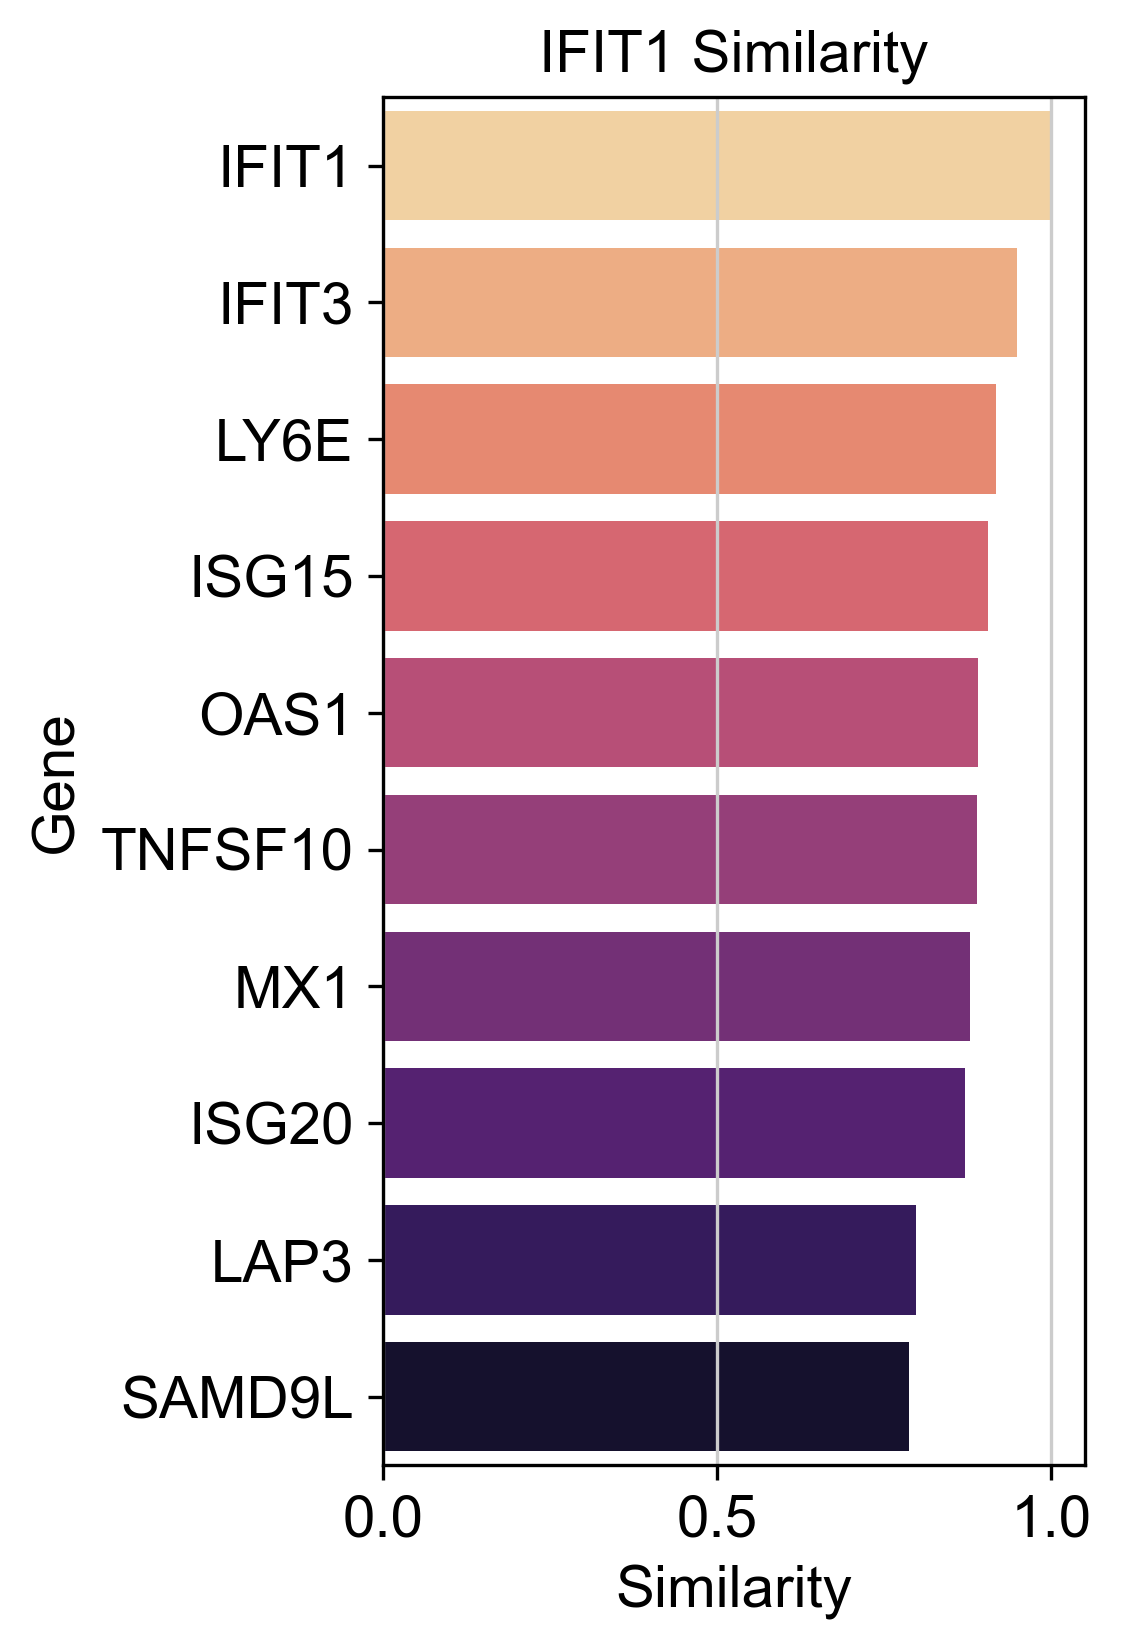

In [9]:
embed.plot_similarities("IFIT1")

# Build Cell Embedding

normalizing counts per cell
    finished (0:00:00)
Loading Expression.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14039/14039 [00:03<00:00, 3763.87it/s]

computing neighbors



OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
 

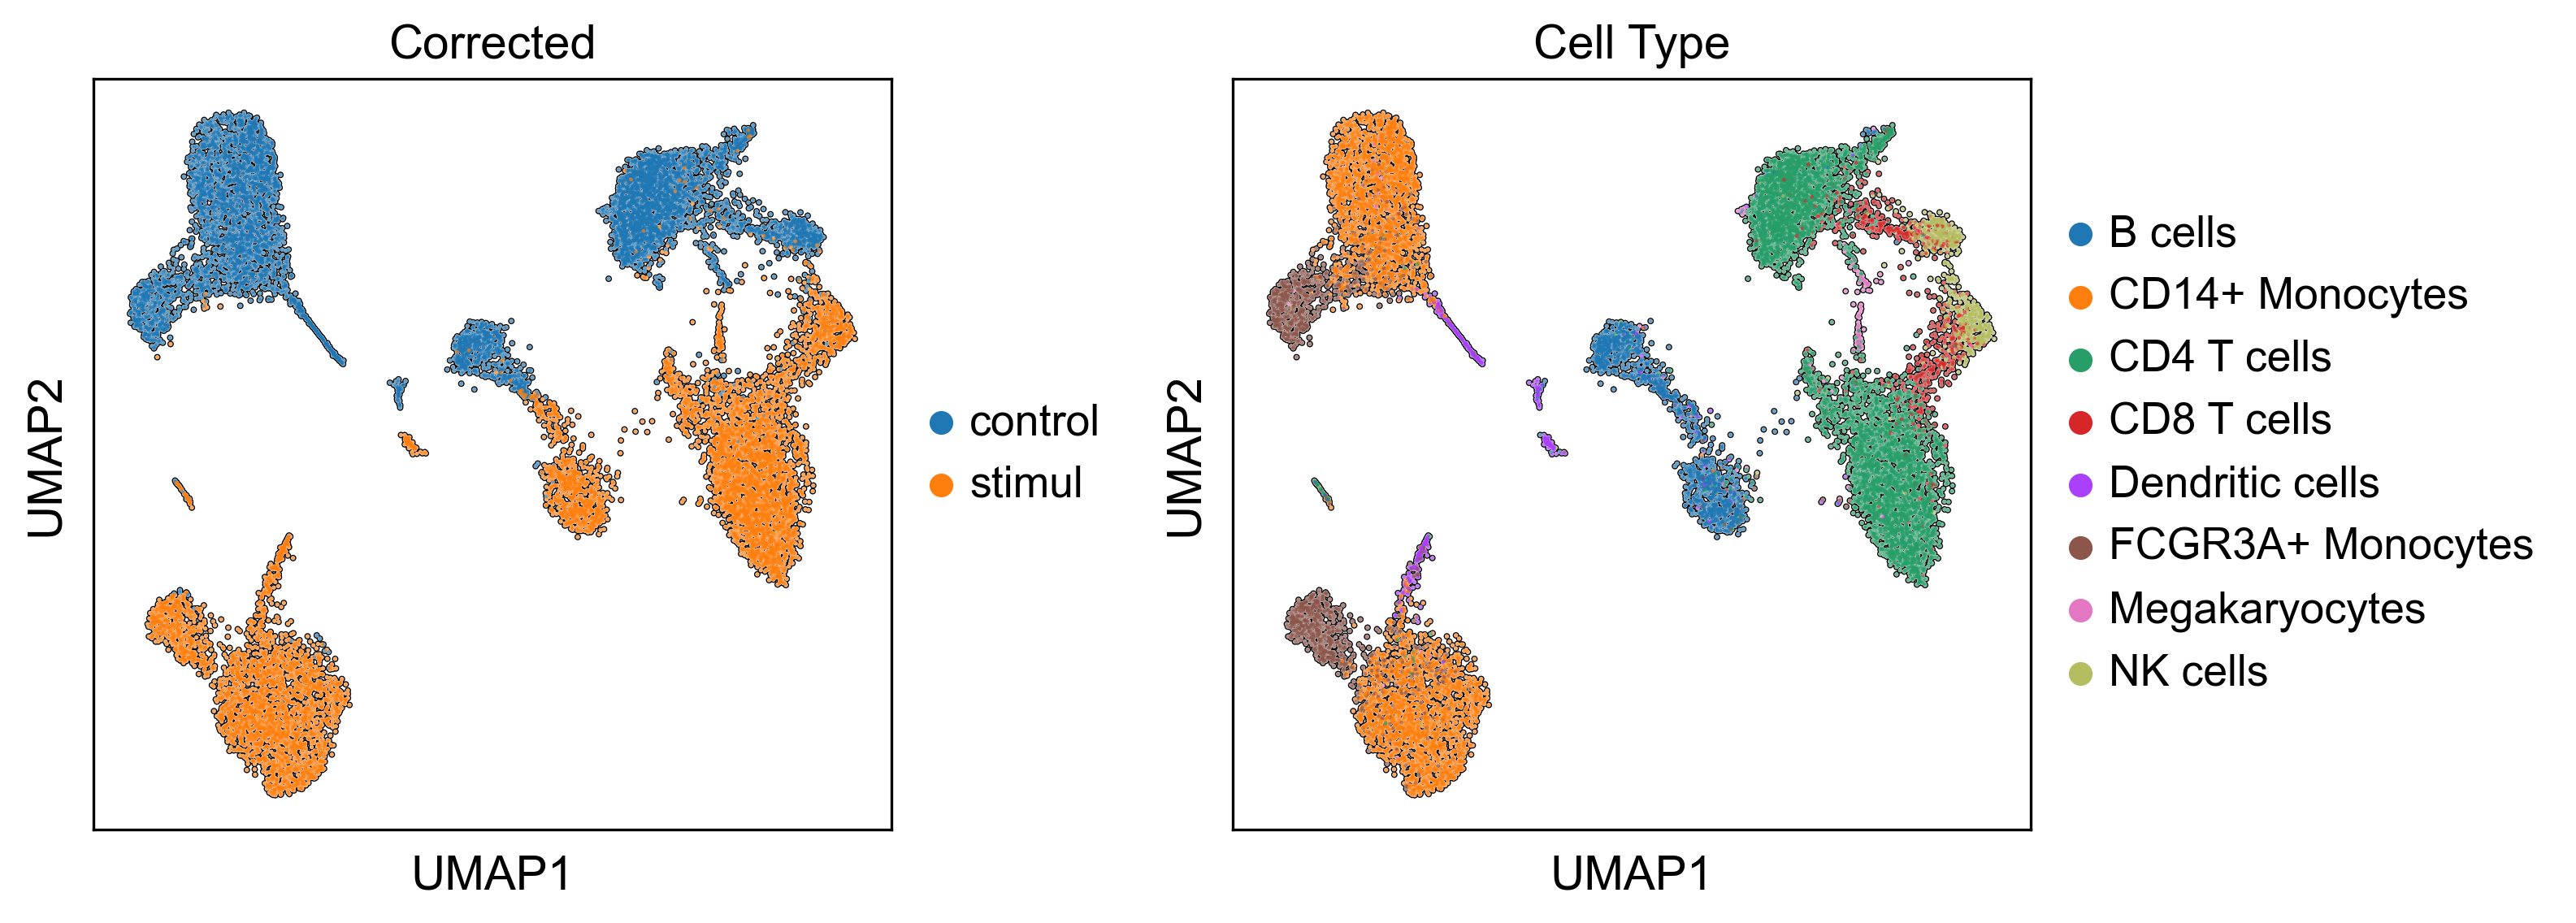

In [10]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
sc.pl.umap(adata,color=["sample","celltype"], wspace=0.3,
                 title=["Corrected","Cell Type"],add_outline=True,size=5)

# Apply Batch Correction

Generating batch vectors.
Computing correction vector for stimul.
Applying correction vectors.
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
 

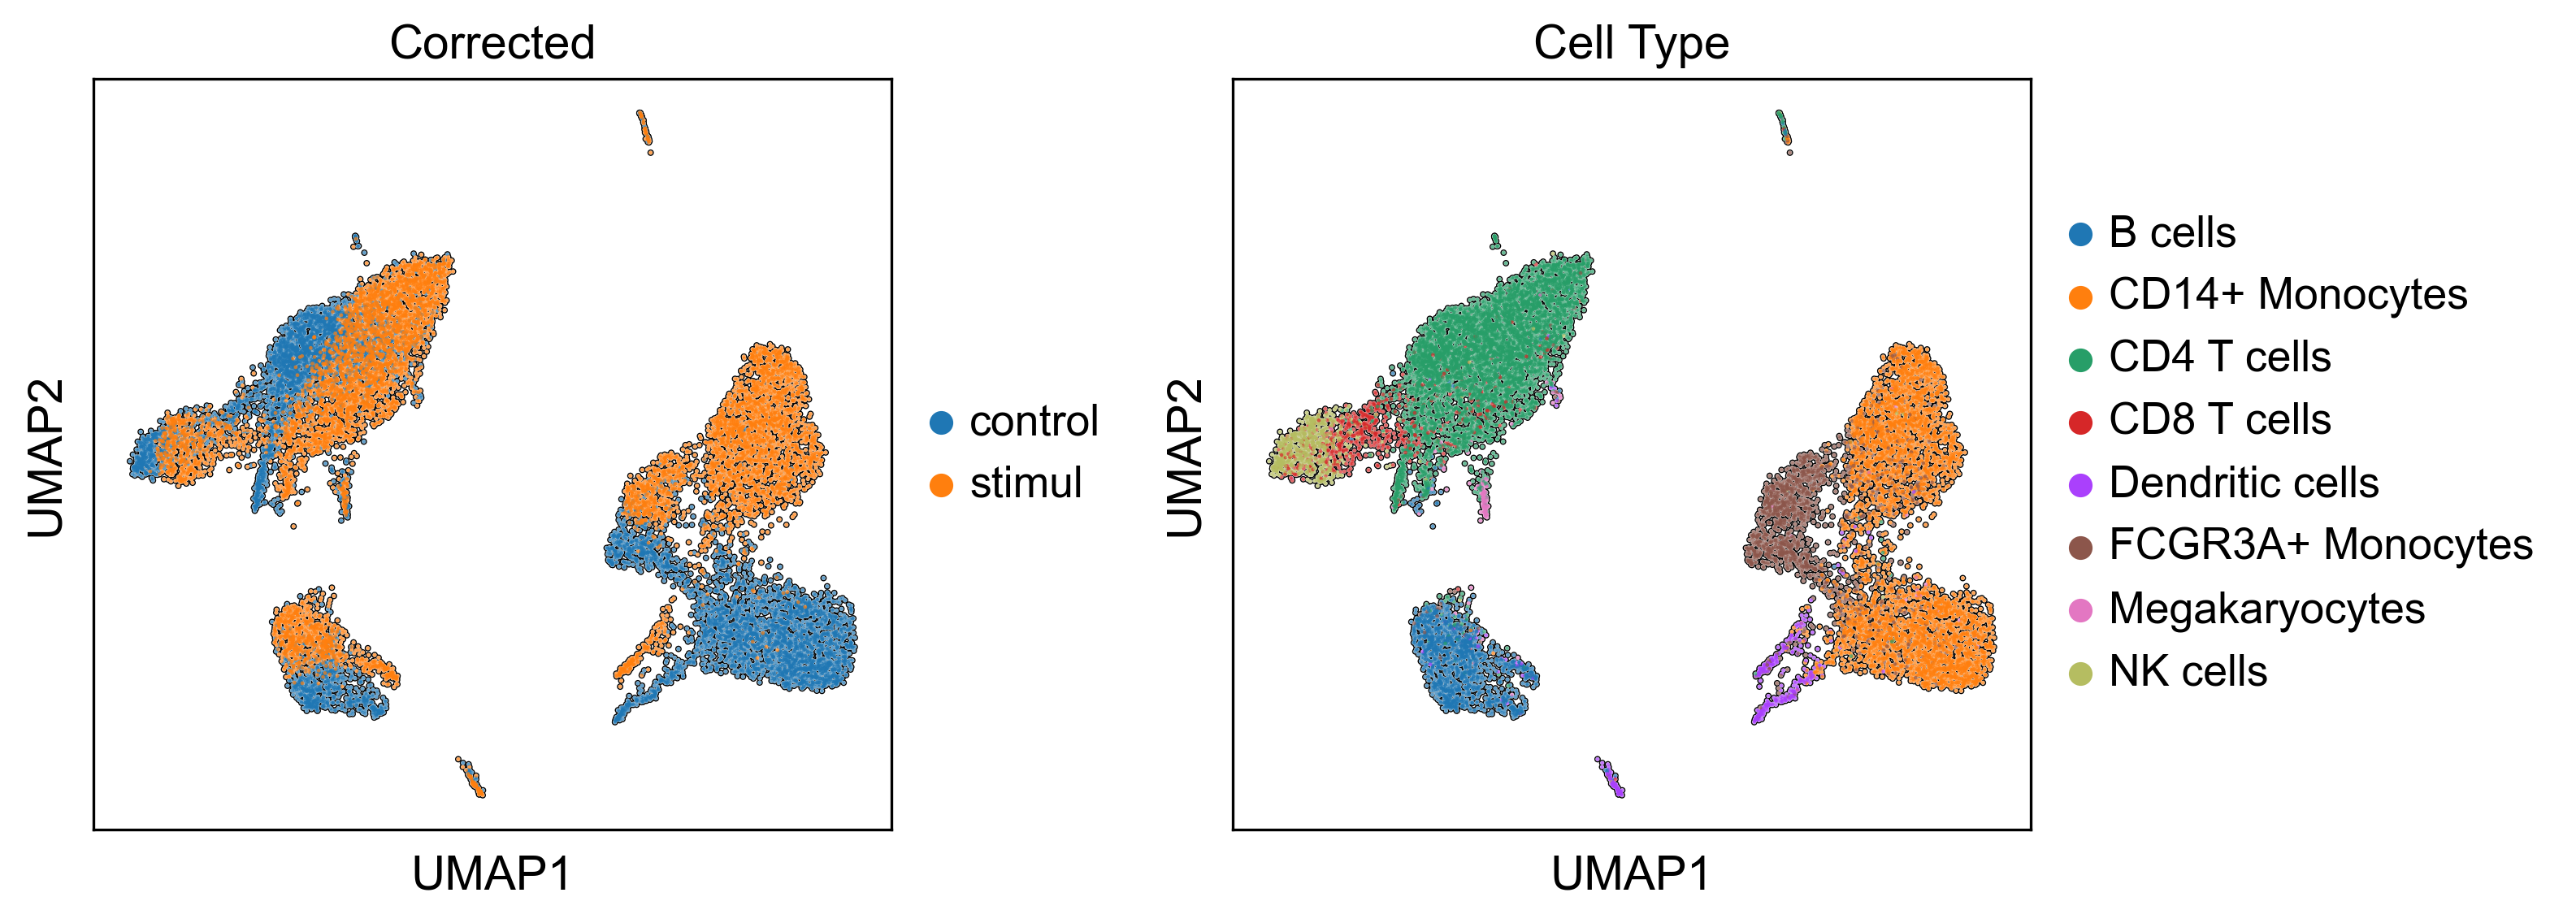

In [11]:
cembed.batch_correct(column="sample",reference="control")
adata = cembed.get_adata()
sc.pl.umap(adata,color=["sample","celltype"], wspace=0.3,
                                 title=["Corrected","Cell Type"],add_outline=True,size=5, save="pbmc.pdf")



# Generate Metagenes

In [28]:
gdata = embed.get_adata(resolution=40)
metagenes = embed.get_metagenes(gdata)

# Find ISG Metagene

In [13]:
for mg, genes in metagenes.items():
    if "IFIT1" in genes:
        print(mg, genes)
        isg_metagene = mg

1 ['ISG15', 'RSAD2', 'TNFSF10', 'LY6E', 'IFIT2', 'IFIT3', 'IFIT1', 'IFITM3', 'OAS1', 'ISG20', 'MX1']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


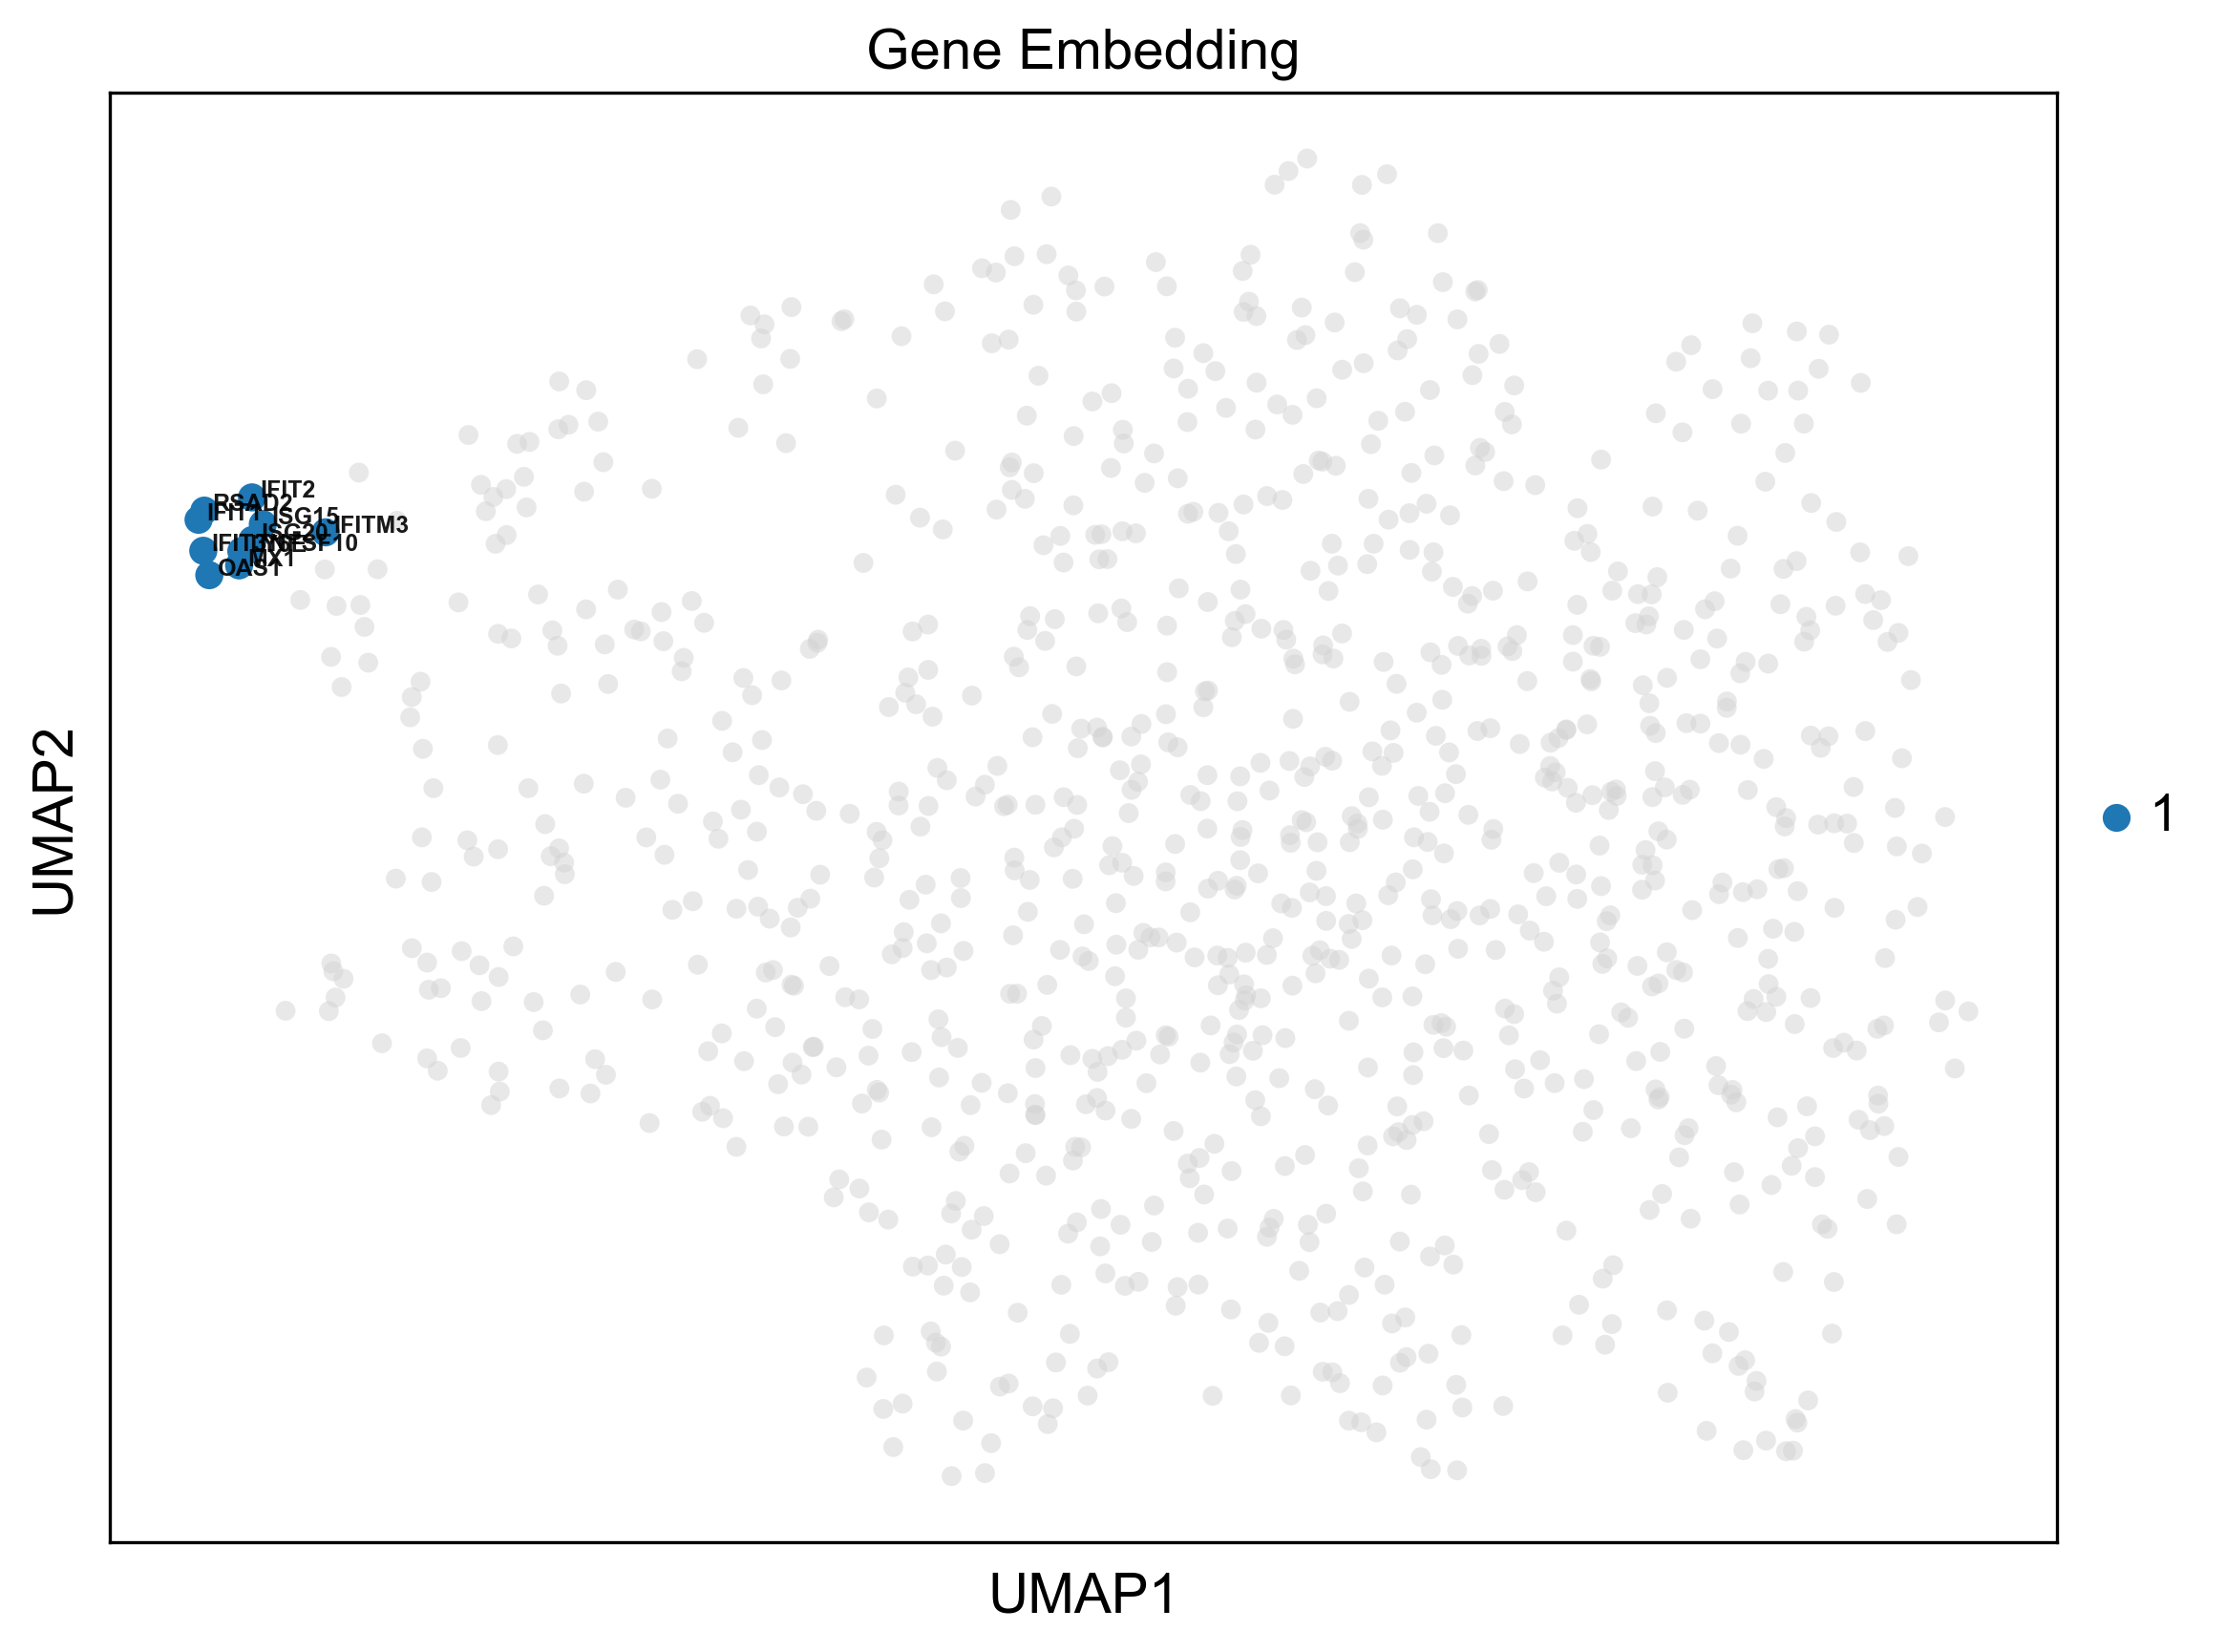

In [14]:
embed.plot_metagene(gdata, mg=isg_metagene)

In [27]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
embed.score_metagenes(adata, metagenes)

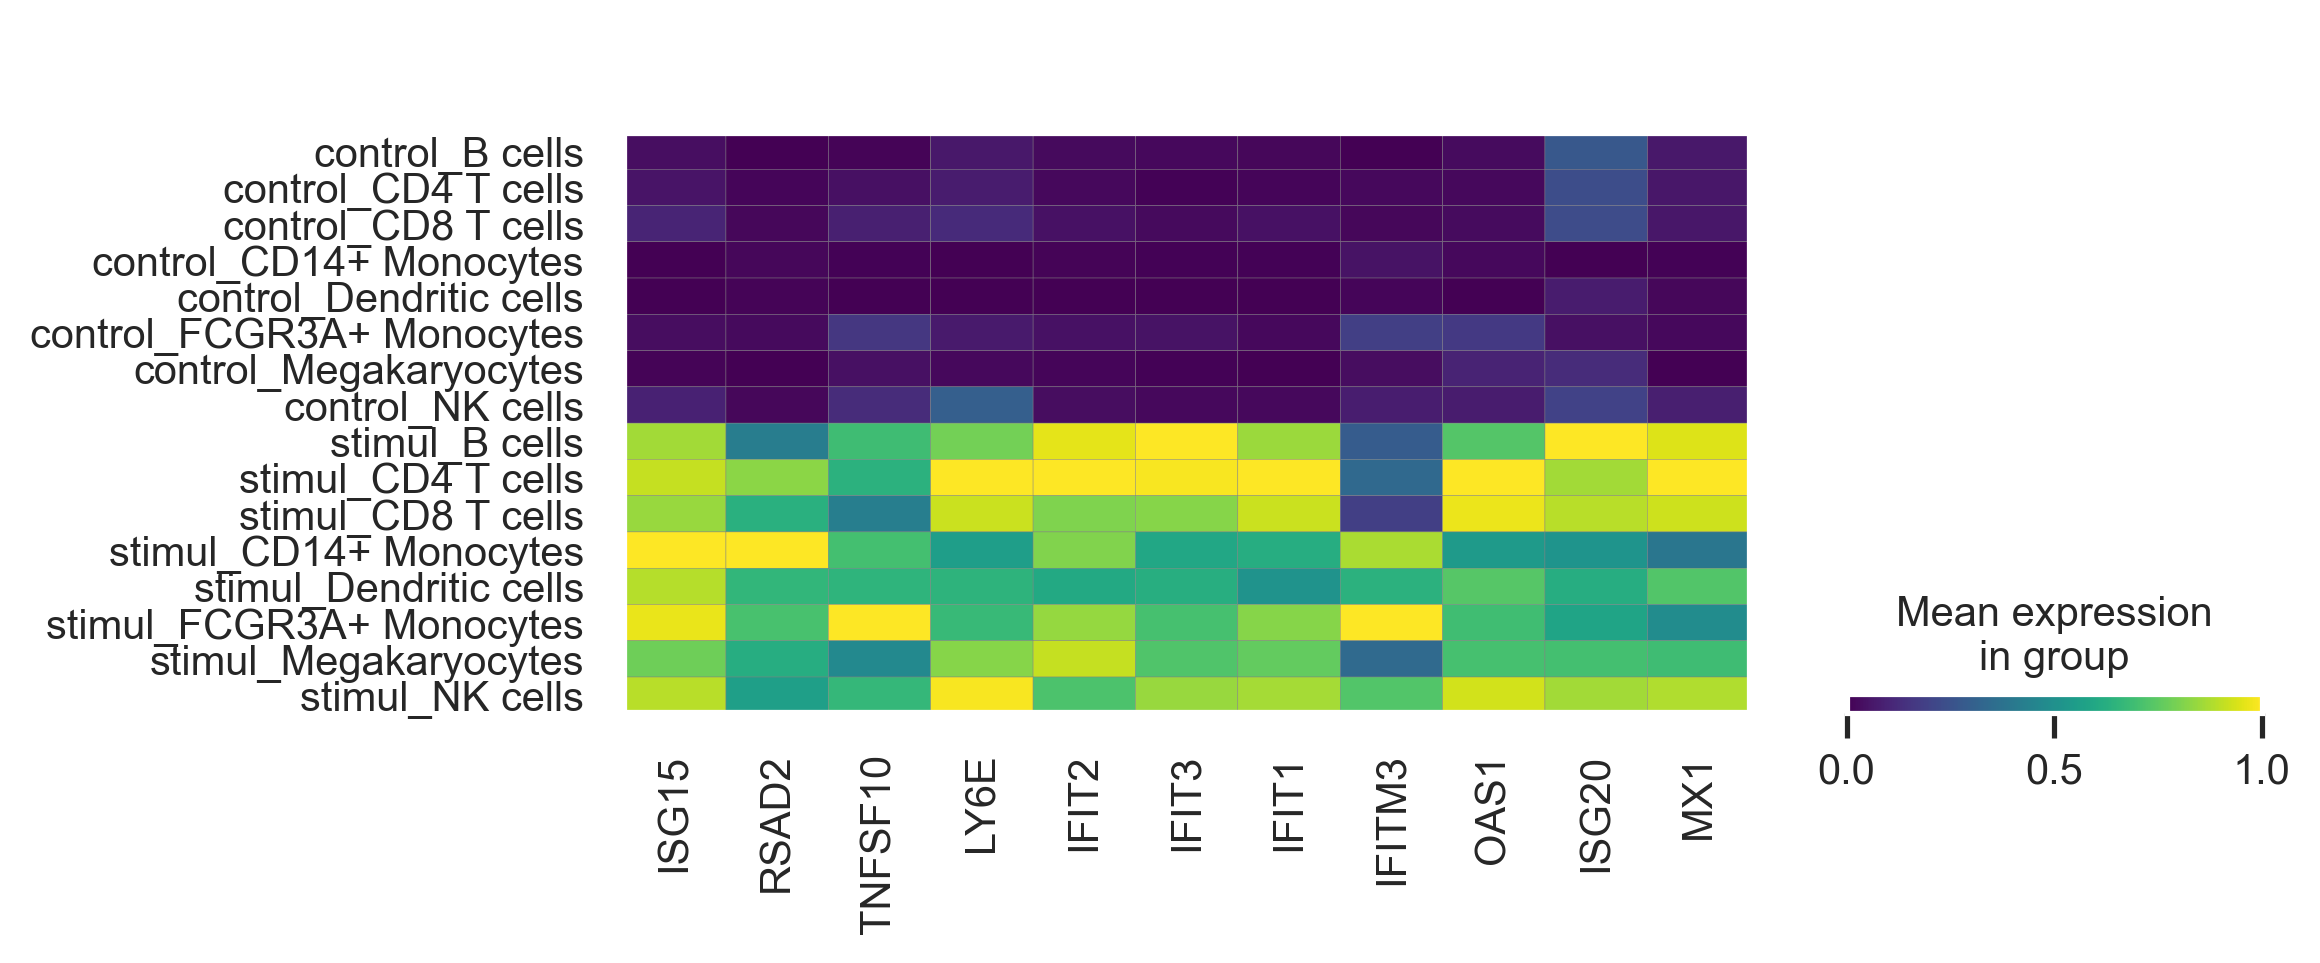

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.)
fig,ax = plt.subplots(1,1,figsize=(7,3))
sc.pl.matrixplot(adata,metagenes[isg_metagene],groupby="detailed_celltype",standard_scale="var",ax=ax)

# Plot All Metagenes

<Figure size 750x1950 with 0 Axes>

<Figure size 600x600 with 0 Axes>

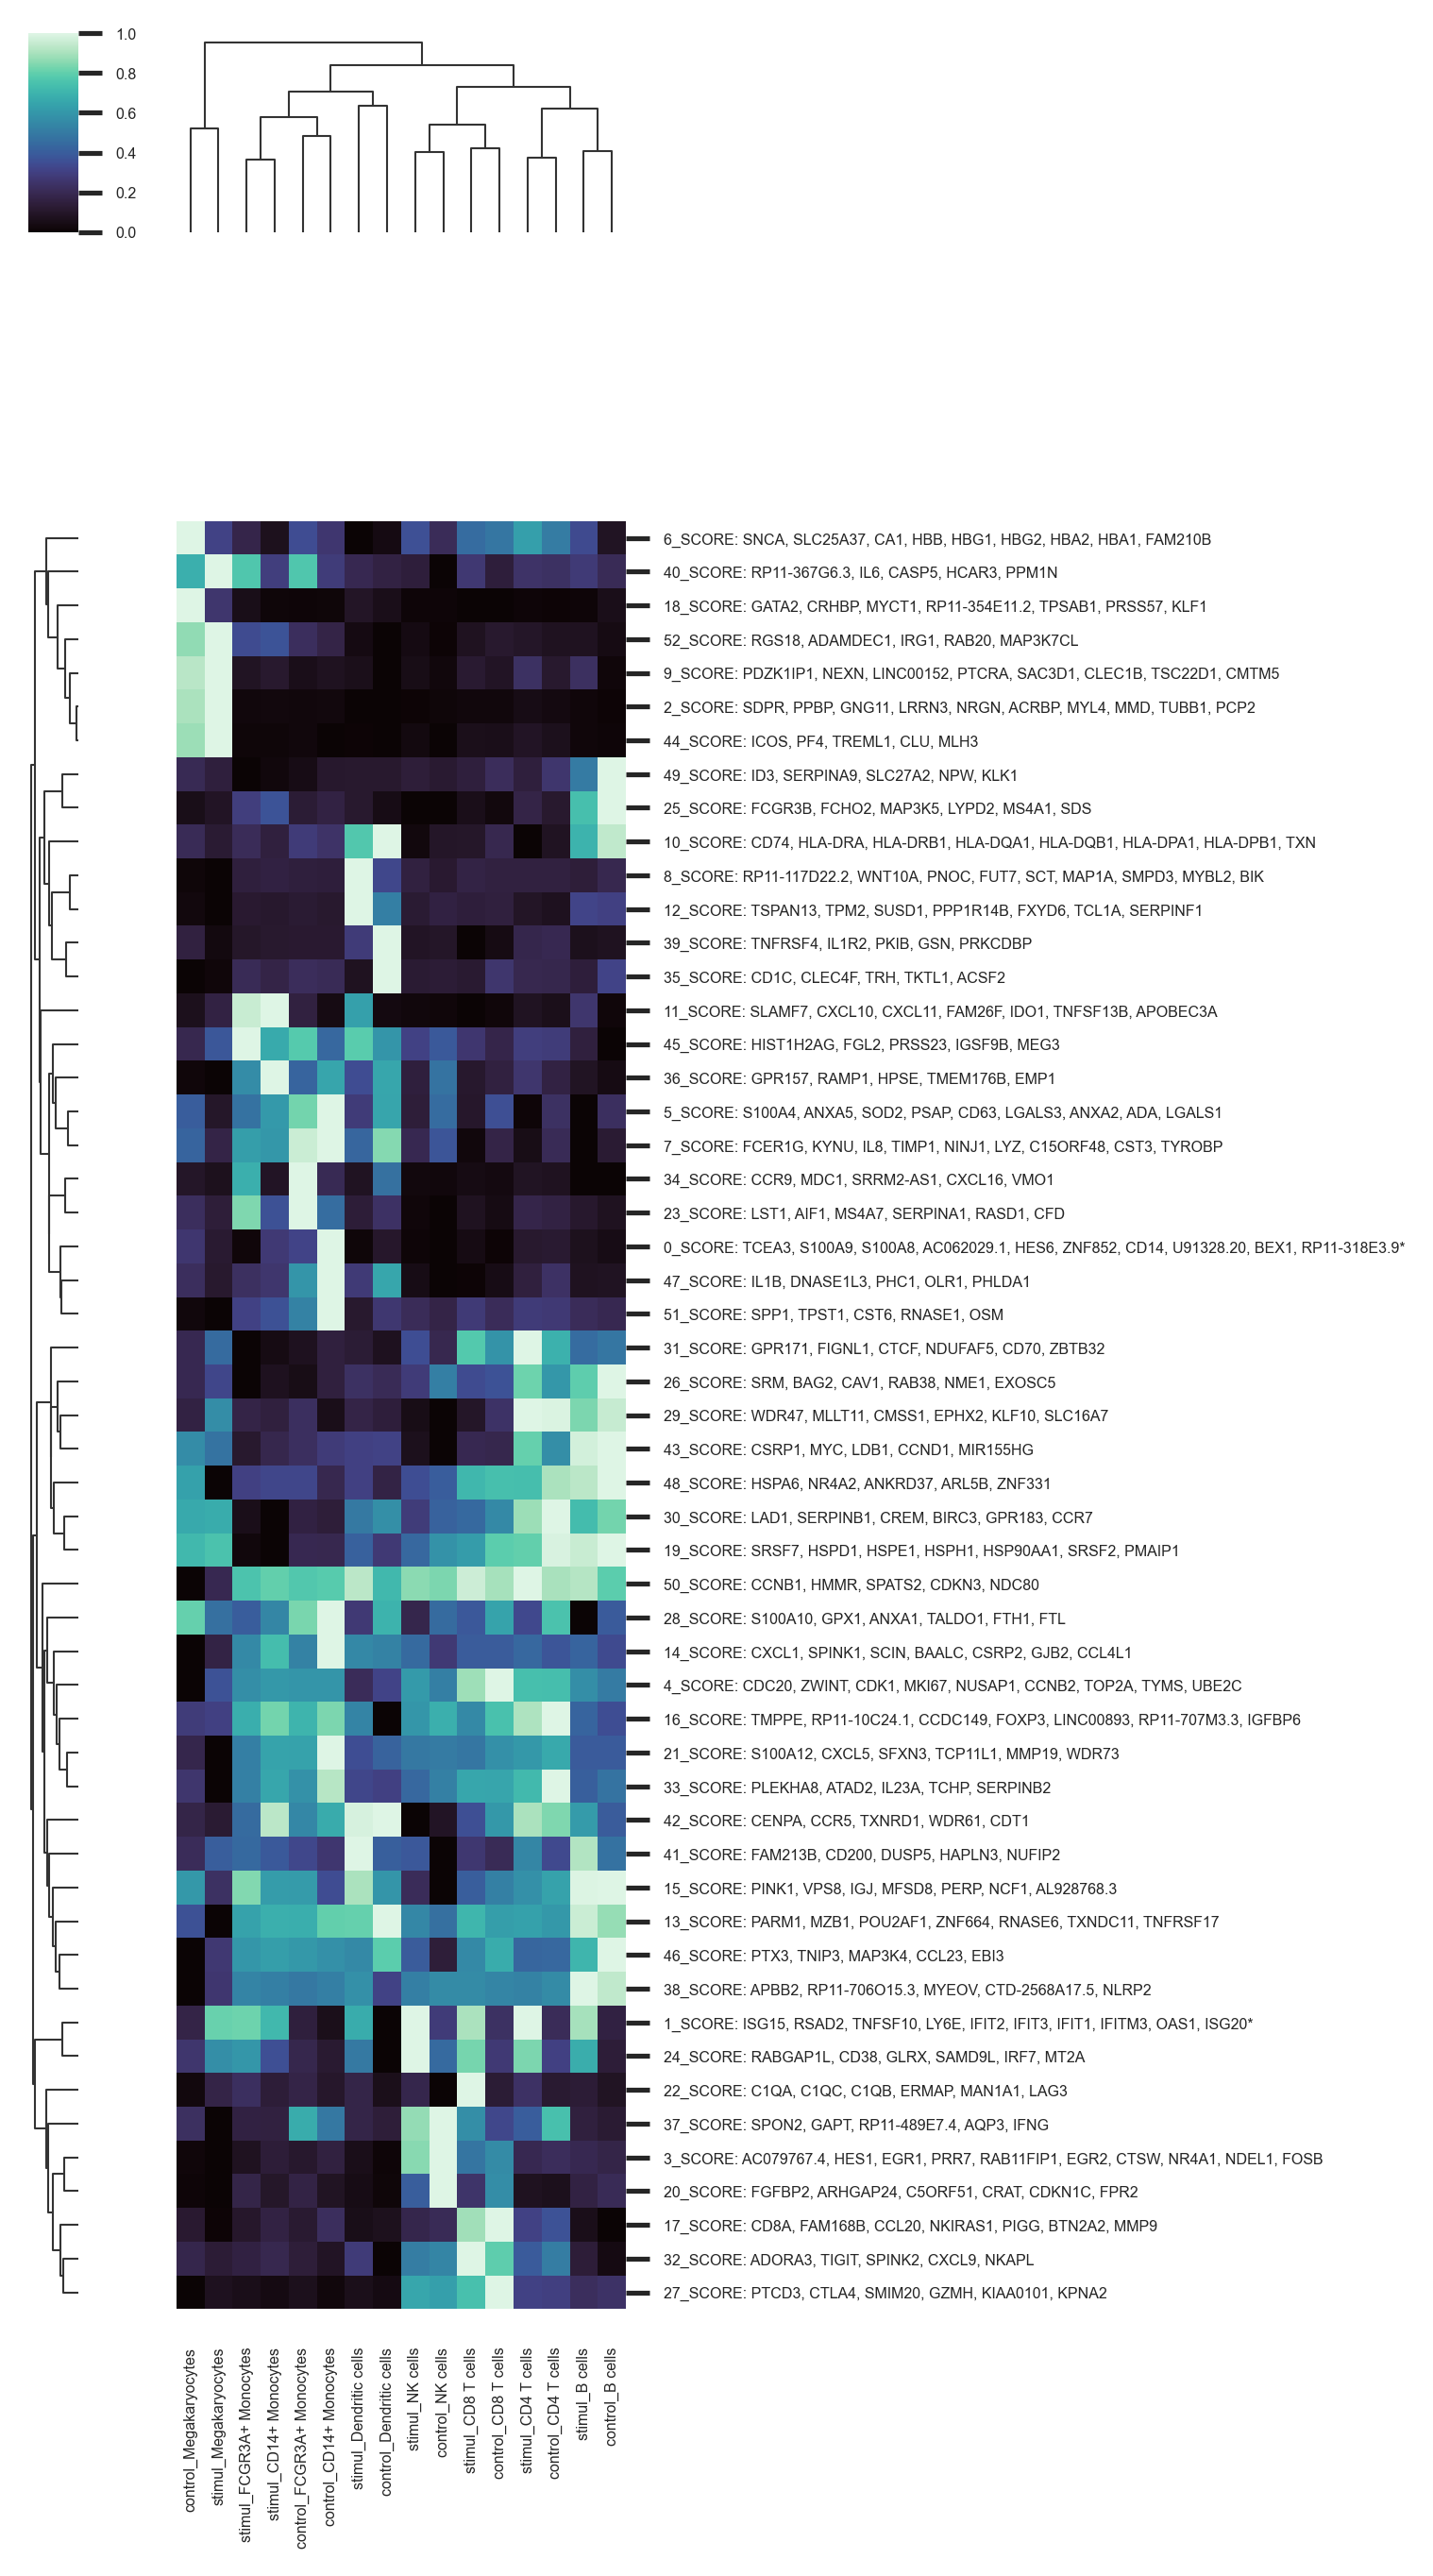

In [25]:
import numpy
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

sns.set(font_scale=0.35)

embed.plot_metagenes_scores(adata,mgs,"detailed_celltype")

# Compute PCA Loadings for Comparison

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


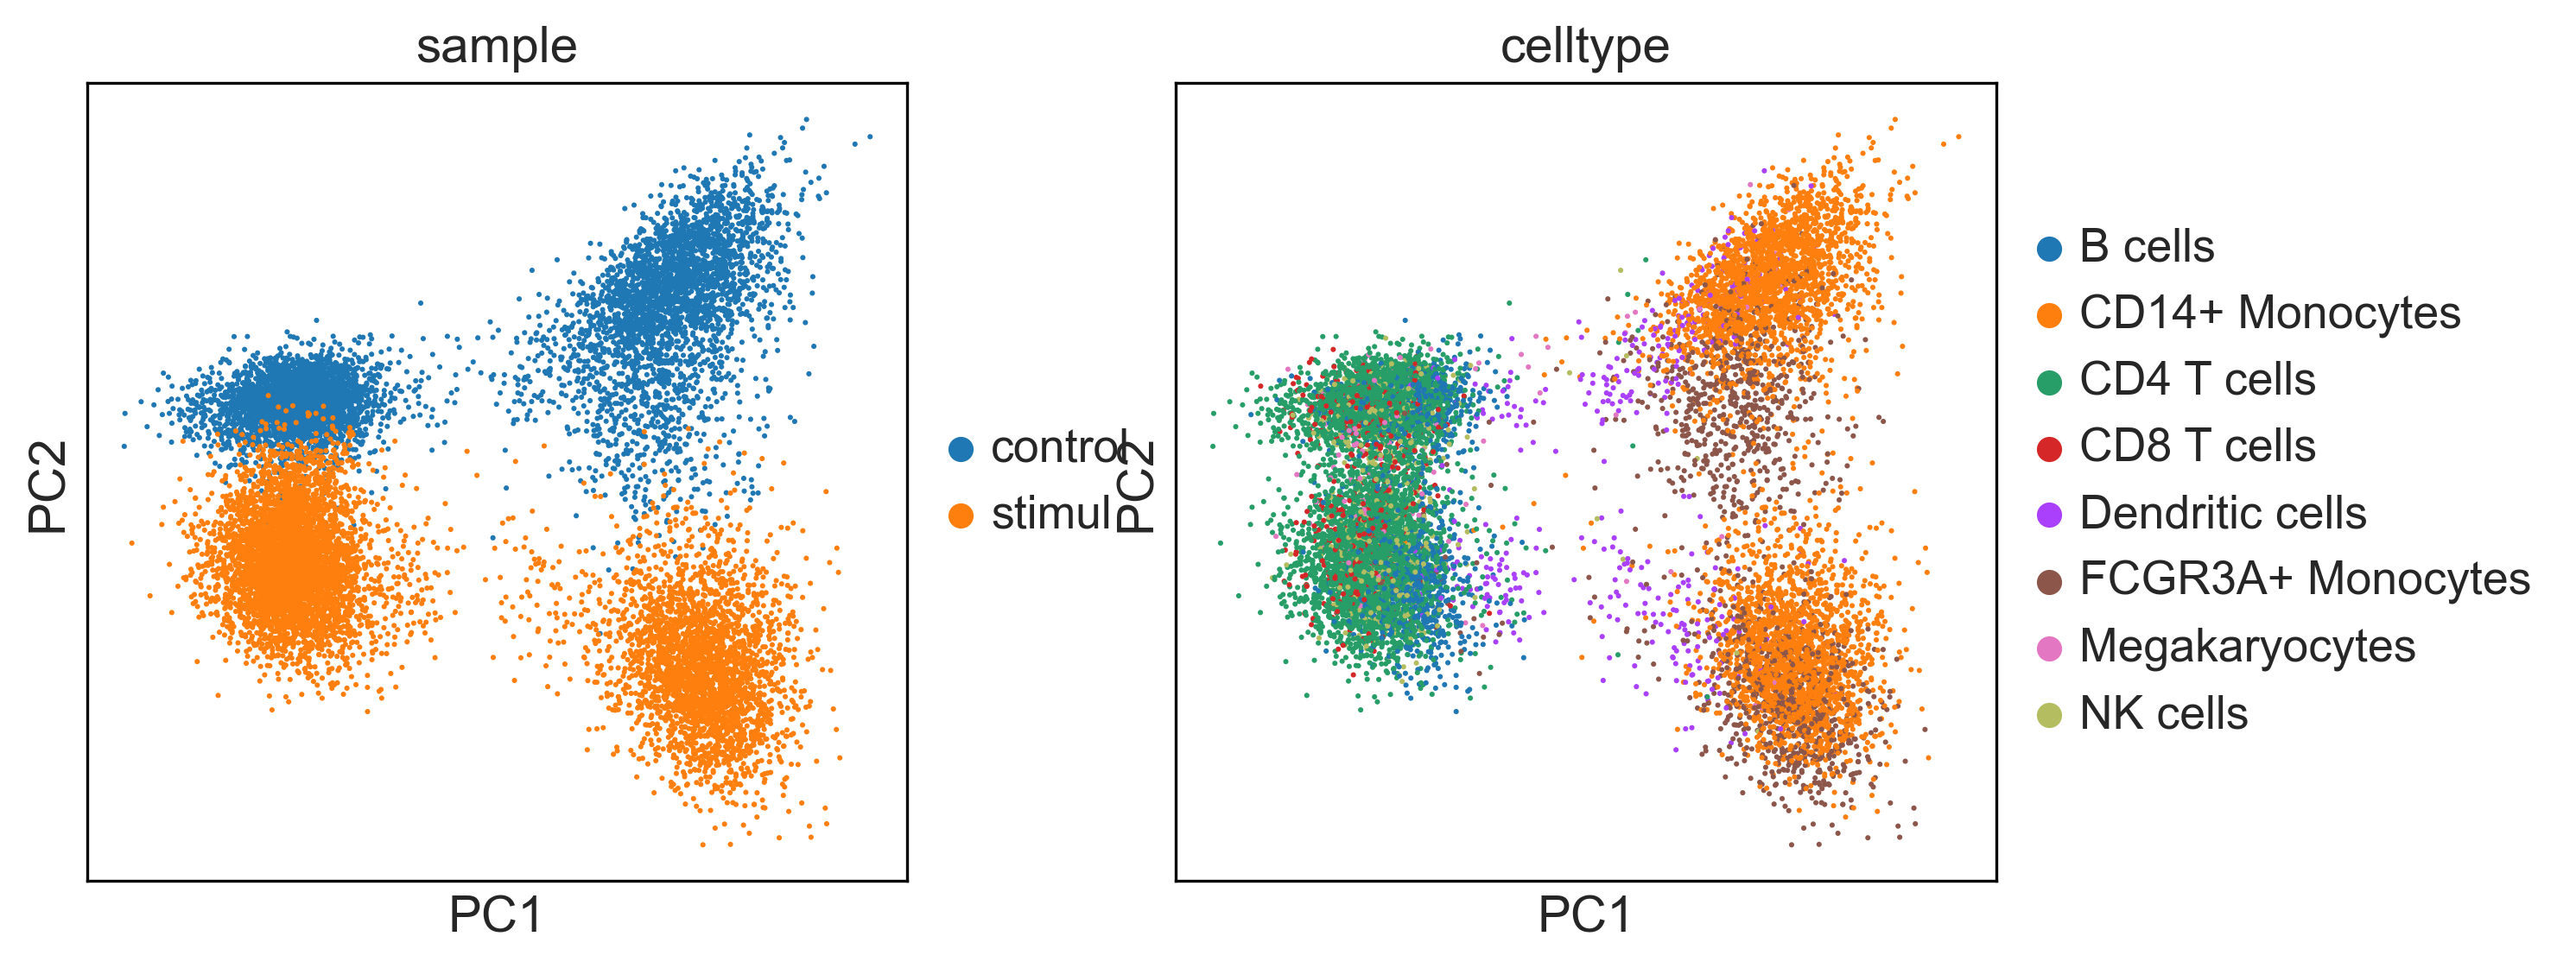

/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_utils.py:288: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_utils.py:288: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/Users/ceglian/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


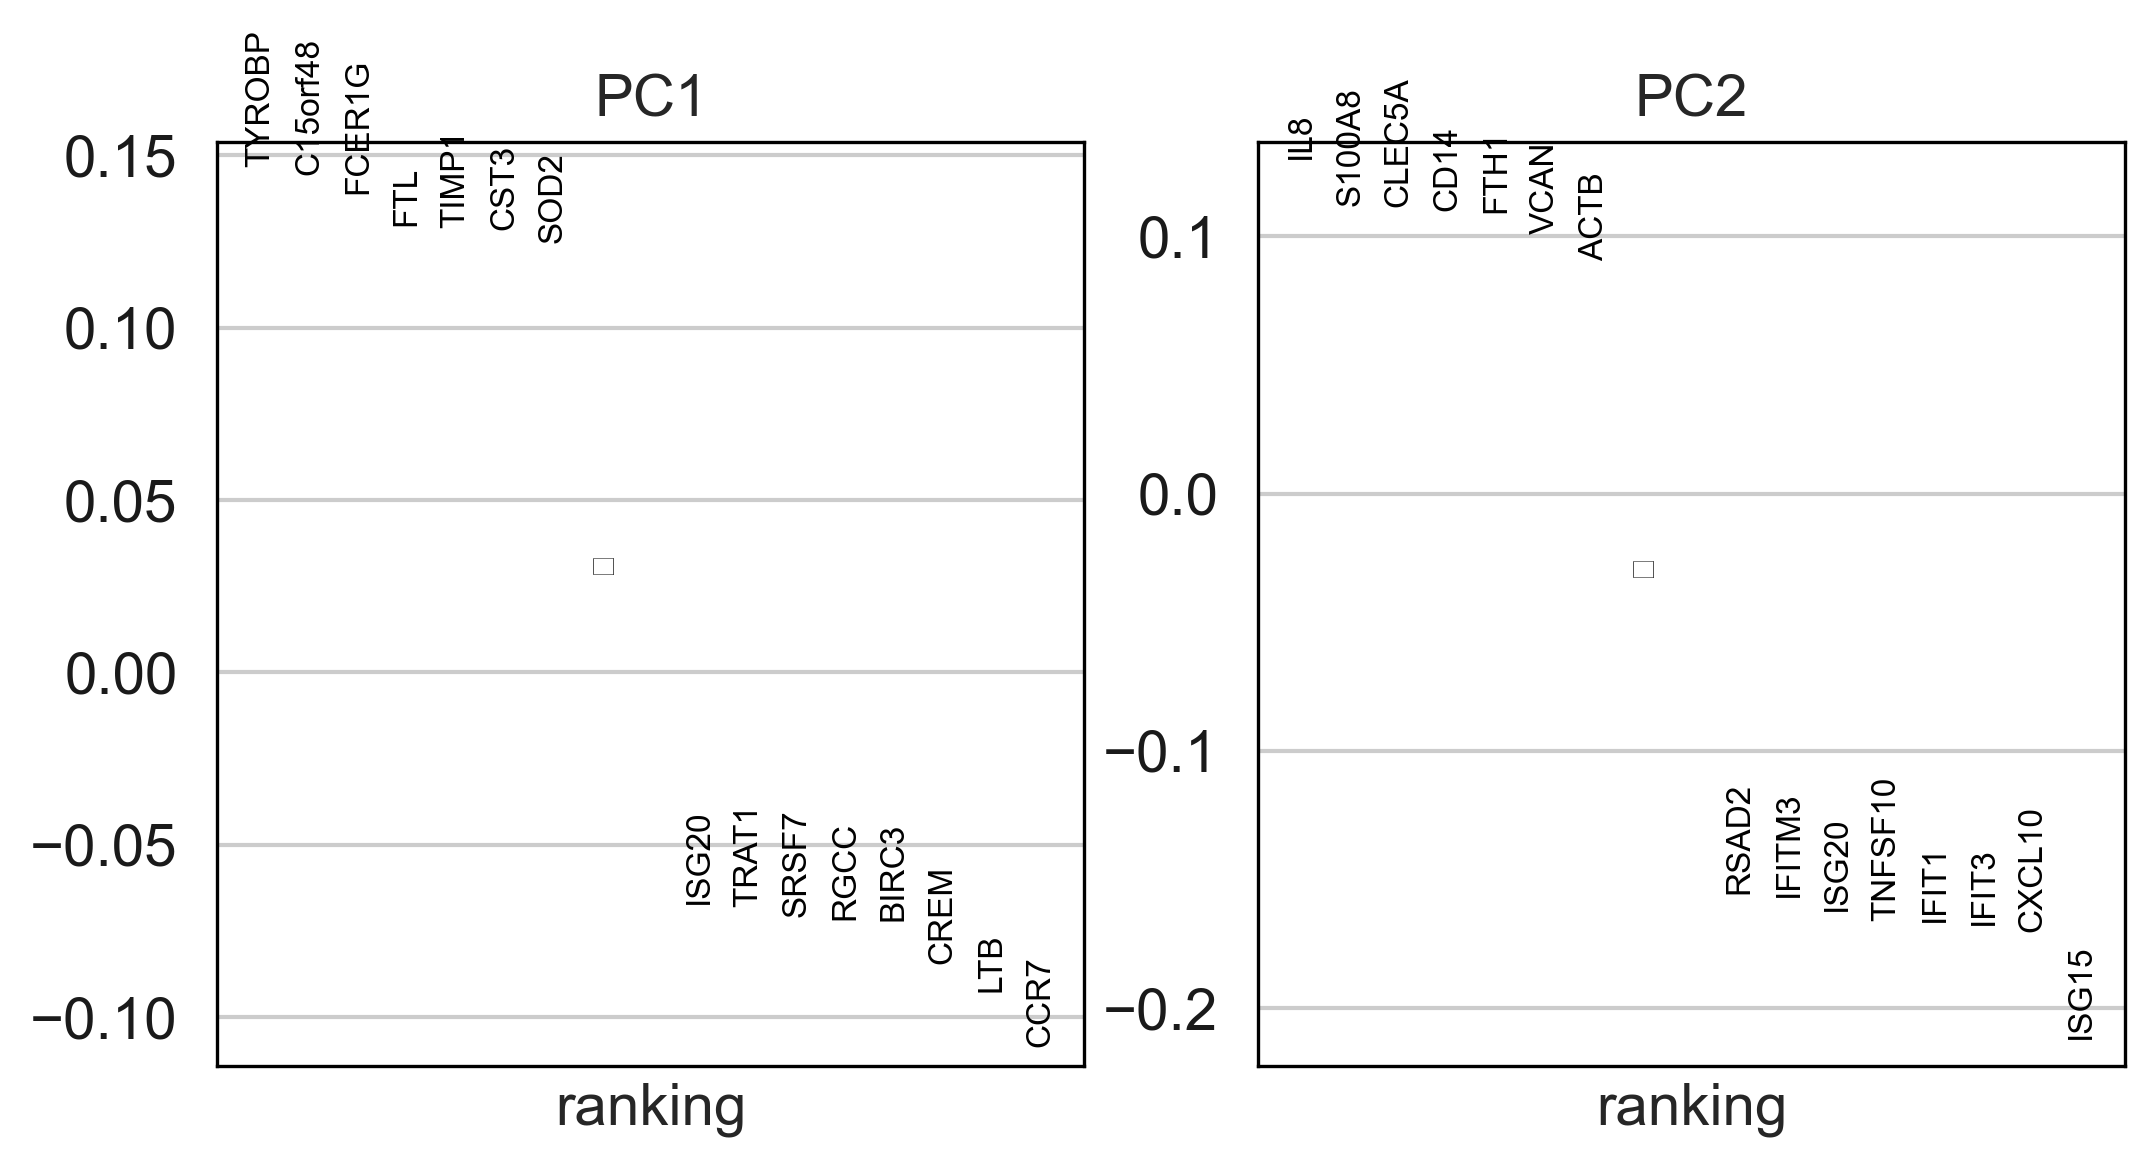

In [26]:
import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150,facecolor='white')

adata = sc.read("PBMC.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)
sc.tl.pca(adata)
sc.pl.pca(adata, color=["sample","celltype"],save="pca.pdf",ncols=2)
sc.pl.pca_loadings(adata, components = '1,2',n_points=15,include_lowest=True, save="loadings.pdf")

# Run Correlation-based GeneVector (for comparison)

In [29]:
adata = sc.read("PBMC.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [30]:
dataset = GeneVectorDataset(adata)

Loading Expression.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1051348/1051348 [00:01<00:00, 975533.34it/s]


Reindexing Cooc


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14039/14039 [00:00<00:00, 59090.89it/s]


In [31]:
cmps = GeneVector(dataset,
                  output_file="pbmc_corr.vec",
                  emb_dimension=100,
                  batch_size=1000,
                  c=100000.,
                  correlation=True)

Generating matrix.
Decomposing


1000it [00:00, 1620.55it/s]


In [32]:
cmps.train(1000,threshold=1e-5)

Epoch 0 	Delta-> 4.050184571743012 	Loss: 4.093649744987488
Epoch 1 	Delta-> 2.5643641412258154 	Loss: 1.482862921555837
Epoch 2 	Delta-> 0.841461592912674 	Loss: 0.6471007565657297
Epoch 3 	Delta-> 0.32422865331172945 	Loss: 0.3196066339810689
Epoch 4 	Delta-> 0.14336206316947936 	Loss: 0.1777769481142362
Epoch 5 	Delta-> 0.06946521662175656 	Loss: 0.10701070477565129
Epoch 6 	Delta-> 0.03564733974635602 	Loss: 0.07098541582624117
Epoch 7 	Delta-> 0.022997912019491196 	Loss: 0.04876412761708101
Epoch 8 	Delta-> 0.013613151758909224 	Loss: 0.03509732348223527
Epoch 9 	Delta-> 0.007827906683087346 	Loss: 0.02735332107792298
Epoch 10 	Delta-> 0.006255556084215644 	Loss: 0.021168276605506738
Epoch 11 	Delta-> 0.00393365598283708 	Loss: 0.01685599082460006
Epoch 12 	Delta-> 0.0032213941682130084 	Loss: 0.013711792758355539
Epoch 13 	Delta-> 0.002248852886259556 	Loss: 0.011670515965670347
Epoch 14 	Delta-> 0.0018999506253749143 	Loss: 0.009677229666461546
Epoch 15 	Delta-> 0.00104203673545

In [34]:
import random
rembed = GeneEmbedding("pbmc_corr.vec", dataset, vector="average")
keys = list(embed.embeddings.keys())
rkeys = keys.copy()
random.shuffle(rkeys)
nembeddings=dict()
for k, nk in zip(keys,rkeys):
    nembeddings[nk] = rembed.embeddings[k]
rembed.embeddings=nembeddings

rsimilarities = dict()
for gene in tqdm.tqdm(rembed.genes):
    df = rembed.compute_similarities(gene)
    rsimilarities[gene] = dict(zip(df["Gene"],df["Similarity"]))

Loading average of 1st and 2nd weights.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.87it/s]


# Read Reactome Pathways

In [37]:
import pandas
import tqdm
reactome = open("references/Reactome_2022.txt","r").readlines()
pathways = dict()
for pathway in reactome:
    pathway = pathway.split("\t")
    name = pathway[0]
    genes = pathway[2:]
    pathways[name]=genes
   

# Compare correlation GeneVector to mutual information GeneVector

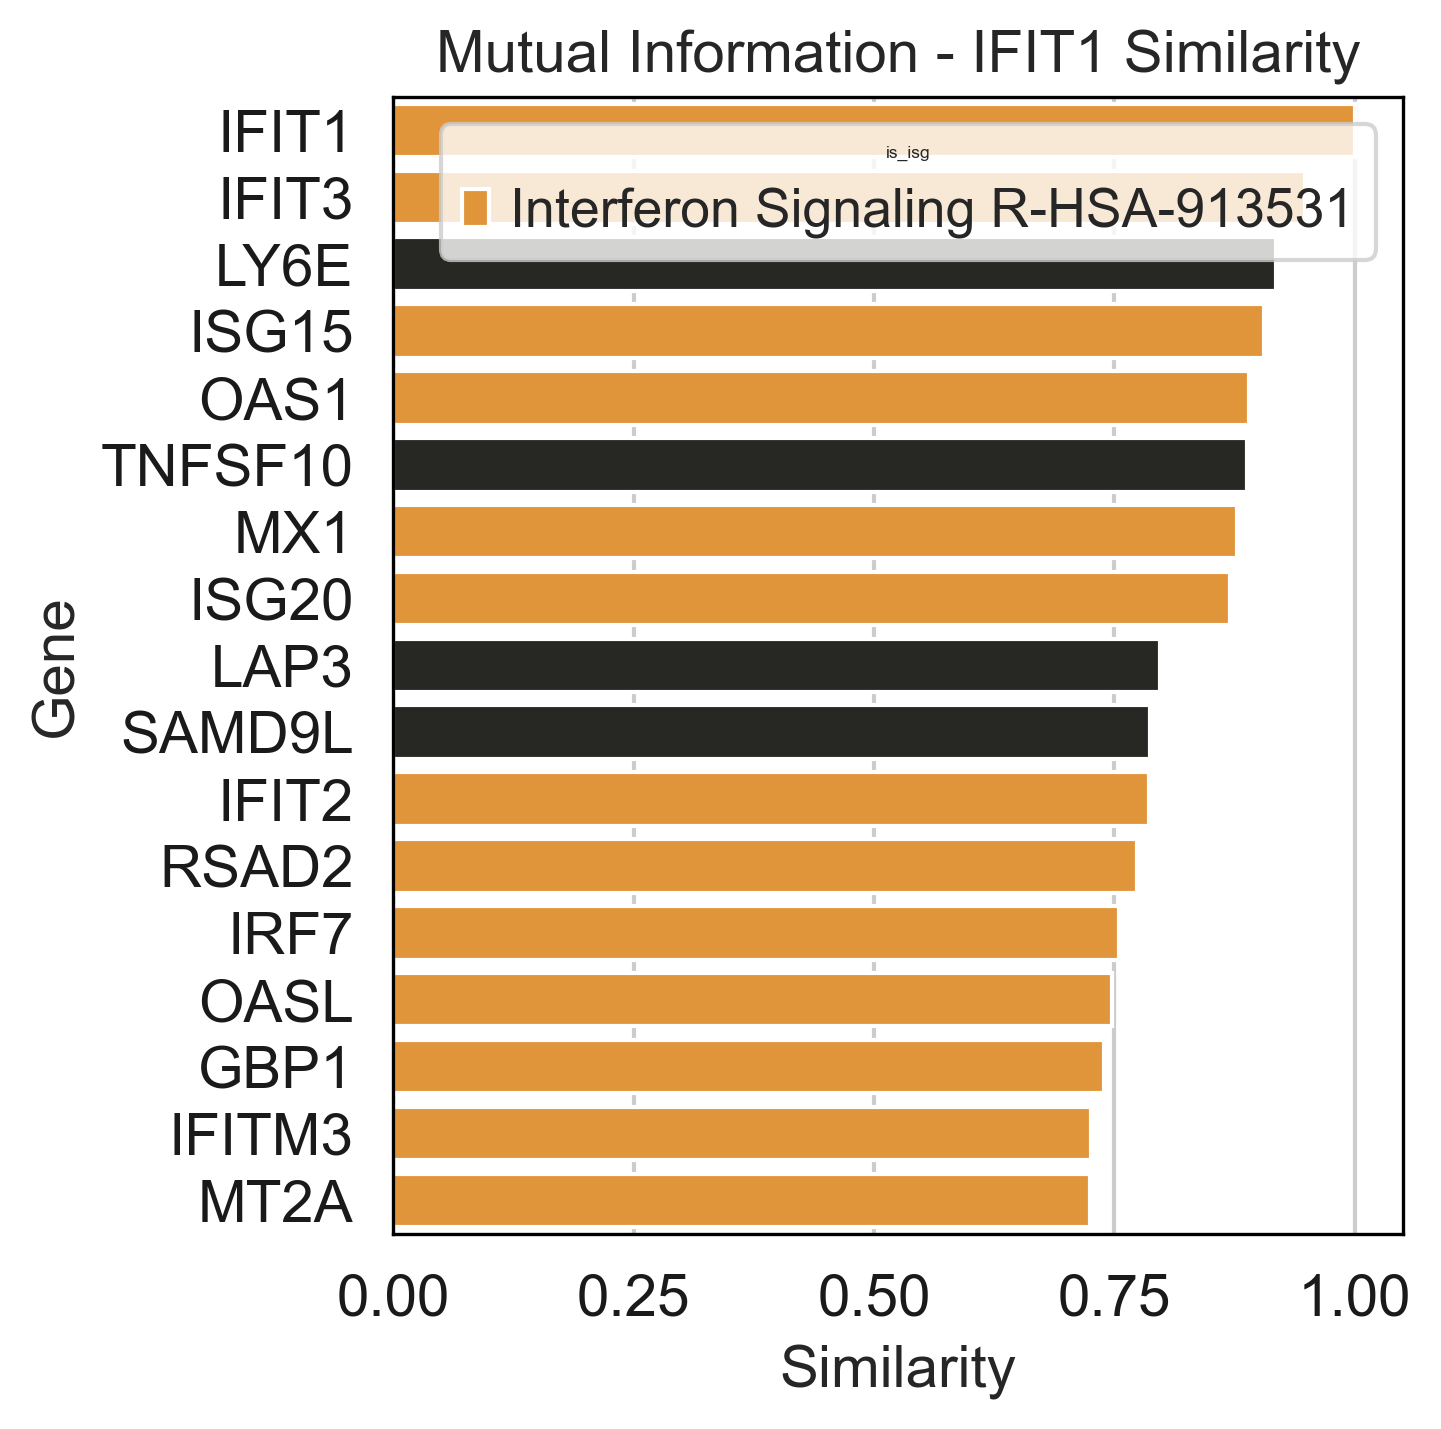

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import tqdm

df = embed.compute_similarities("IFIT1").head(17)
is_isg = []
for g in df["Gene"]:
    if g in pathways["Interferon Signaling R-HSA-913531"]:
        is_isg.append("Interferon Signaling R-HSA-913531")
    else:
        is_isg.append("_Other")
df["is_isg"] = is_isg
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.barplot(data=df,y="Gene",x="Similarity",hue="is_isg",palette=["#FD971F","#272822"],ax=ax,dodge=False)
ax.set_title("Mutual Information - IFIT1 Similarity")
plt.tight_layout()

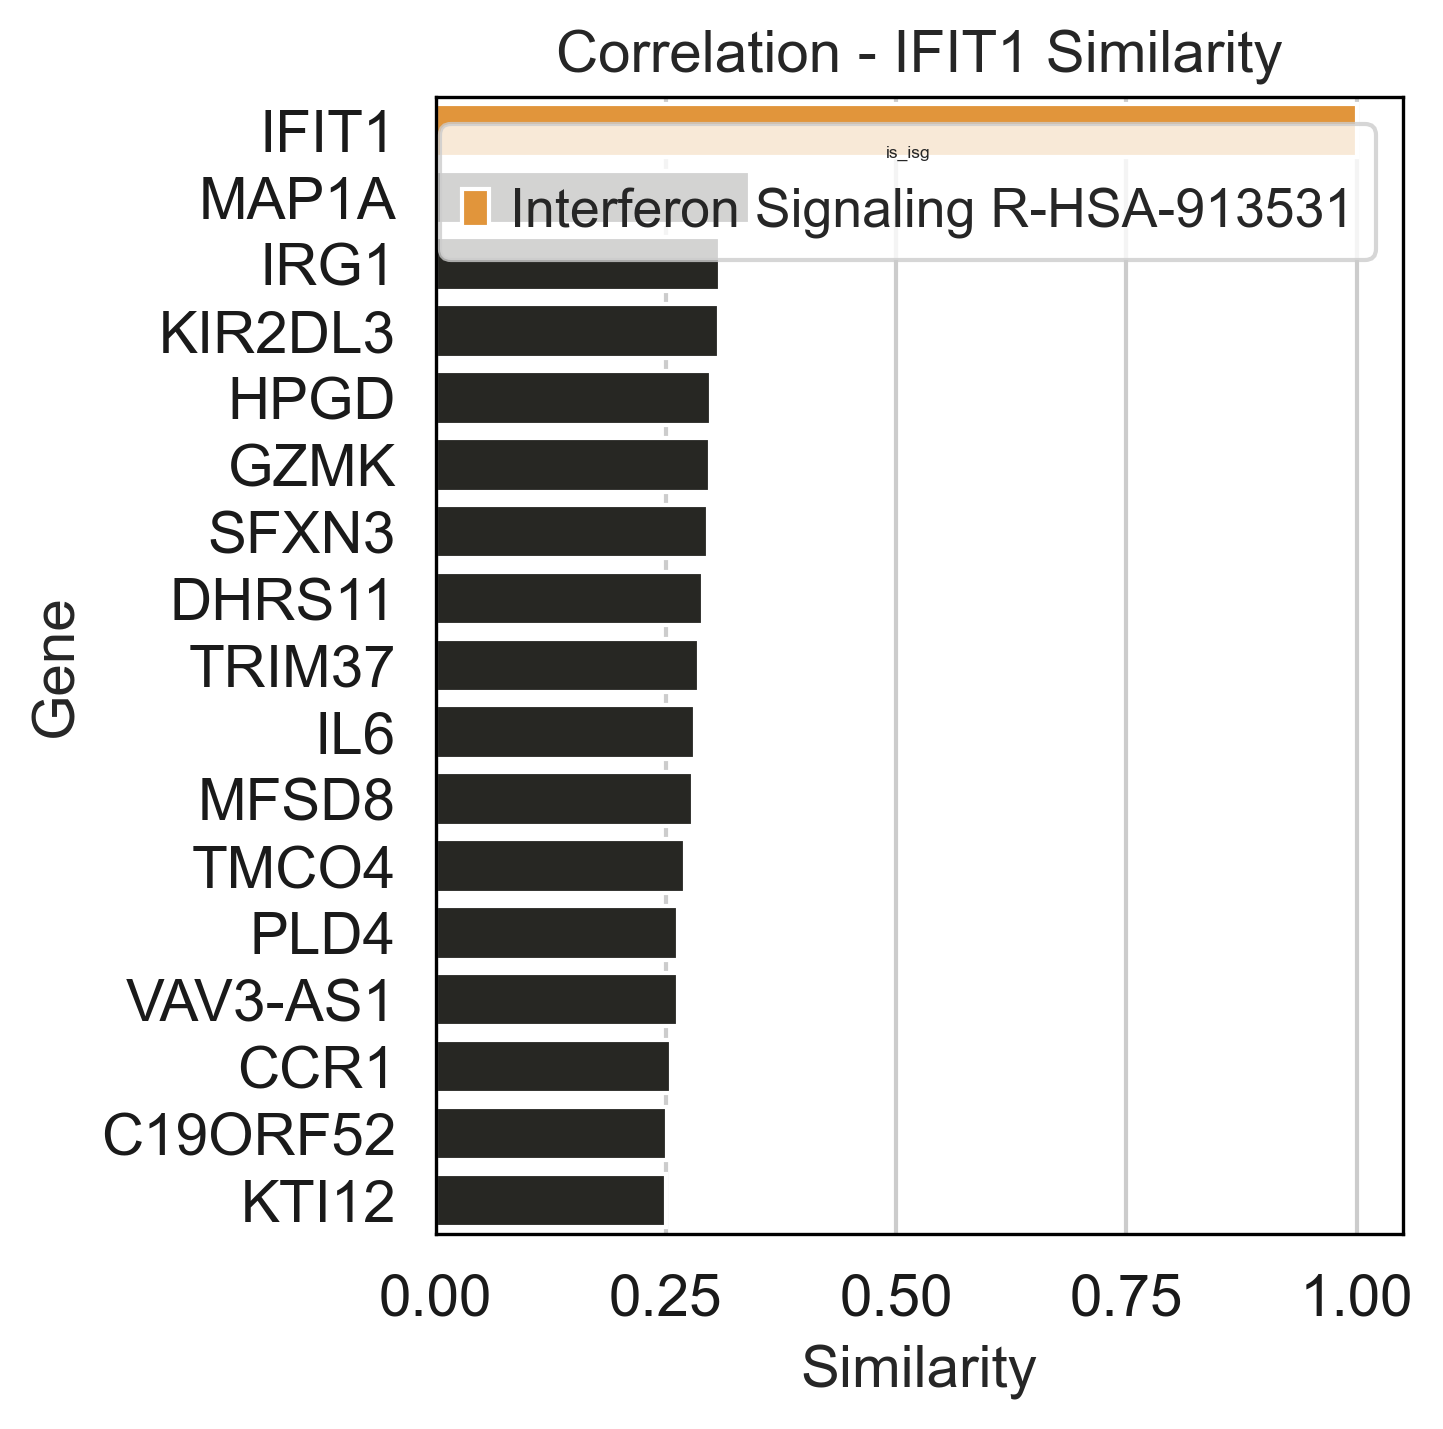

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import tqdm

df = rembed.compute_similarities("IFIT1").head(17)
is_isg = []
for g in df["Gene"]:
    if g in pathways["Interferon Signaling R-HSA-913531"]:
        is_isg.append("Interferon Signaling R-HSA-913531")
    else:
        is_isg.append("_Other")
df["is_isg"] = is_isg
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.barplot(data=df,y="Gene",x="Similarity",hue="is_isg",palette=["#FD971F","#272822"],ax=ax,dodge=False)
ax.set_title("Correlation - IFIT1 Similarity")
plt.tight_layout()

# Compute Reactome Pathway and MSigDB Signature Overlap for Gene Pairs 

In [41]:
import itertools
import collections
pathway_coverage = collections.defaultdict(lambda : collections.defaultdict(int))
for pair in tqdm.tqdm(list(itertools.combinations(embed.genes,2))):
    for pathway, genes in pathways.items():
        if pair[0] in genes and pair[1] in genes:
            pathway_coverage[pair[0]][pair[1]] += 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499500/499500 [11:39<00:00, 714.36it/s]


In [42]:
cts = open("references/c8.all.v2022.1.Hs.symbols.gmt.txt","r").readlines()
celltypes = dict()
for pathway in cts:
    pathway = pathway.split("\t")
    name = pathway[0]
    genes = pathway[2:]
    celltypes[name]=genes
import itertools
import collections
ct_coverage = collections.defaultdict(lambda : collections.defaultdict(int))
for pair in tqdm.tqdm(list(itertools.combinations(embed.genes,2))):
    for pathway, genes in celltypes.items():
        if pair[0] in genes and pair[1] in genes:
            ct_coverage[pair[0]][pair[1]] += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499500/499500 [09:35<00:00, 867.94it/s]


In [43]:
pathway_counts = collections.defaultdict(set)
celltype_counts = collections.defaultdict(set)
for gene in embed.genes:
    for pathway, genes in pathways.items():
        if gene in genes:
            pathway_counts[gene].add(pathway)
    for pathway, genes in celltypes.items():
        if gene in genes:
            celltype_counts[gene].add(pathway)

# Randomly Shuffle Gene Vectors for Correlation and MI

In [46]:
import random
similarities = dict()
for gene in tqdm.tqdm(embed.genes):
    df = embed.compute_similarities(gene)
    similarities[gene] = dict(zip(df["Gene"],df["Similarity"]))     

rsimilarities = dict()
rkeys = list(similarities.keys())
keys = rkeys.copy()
random.shuffle(rkeys)
for o, n in zip(keys,rkeys):
    lkeys = list(similarities[o].keys())
    rlkeys = lkeys.copy()
    random.shuffle(rlkeys)
    shuffsim = dict()
    for ol, nl in zip(lkeys,rlkeys):
        shuffsim[nl] = similarities[o][ol]
    rsimilarities[n] = shuffsim

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.62it/s]


In [47]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

# Generate Figures for Correlation of Pathway/Signature and Cosine Similarity

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499500/499500 [00:00<00:00, 2240633.27it/s]


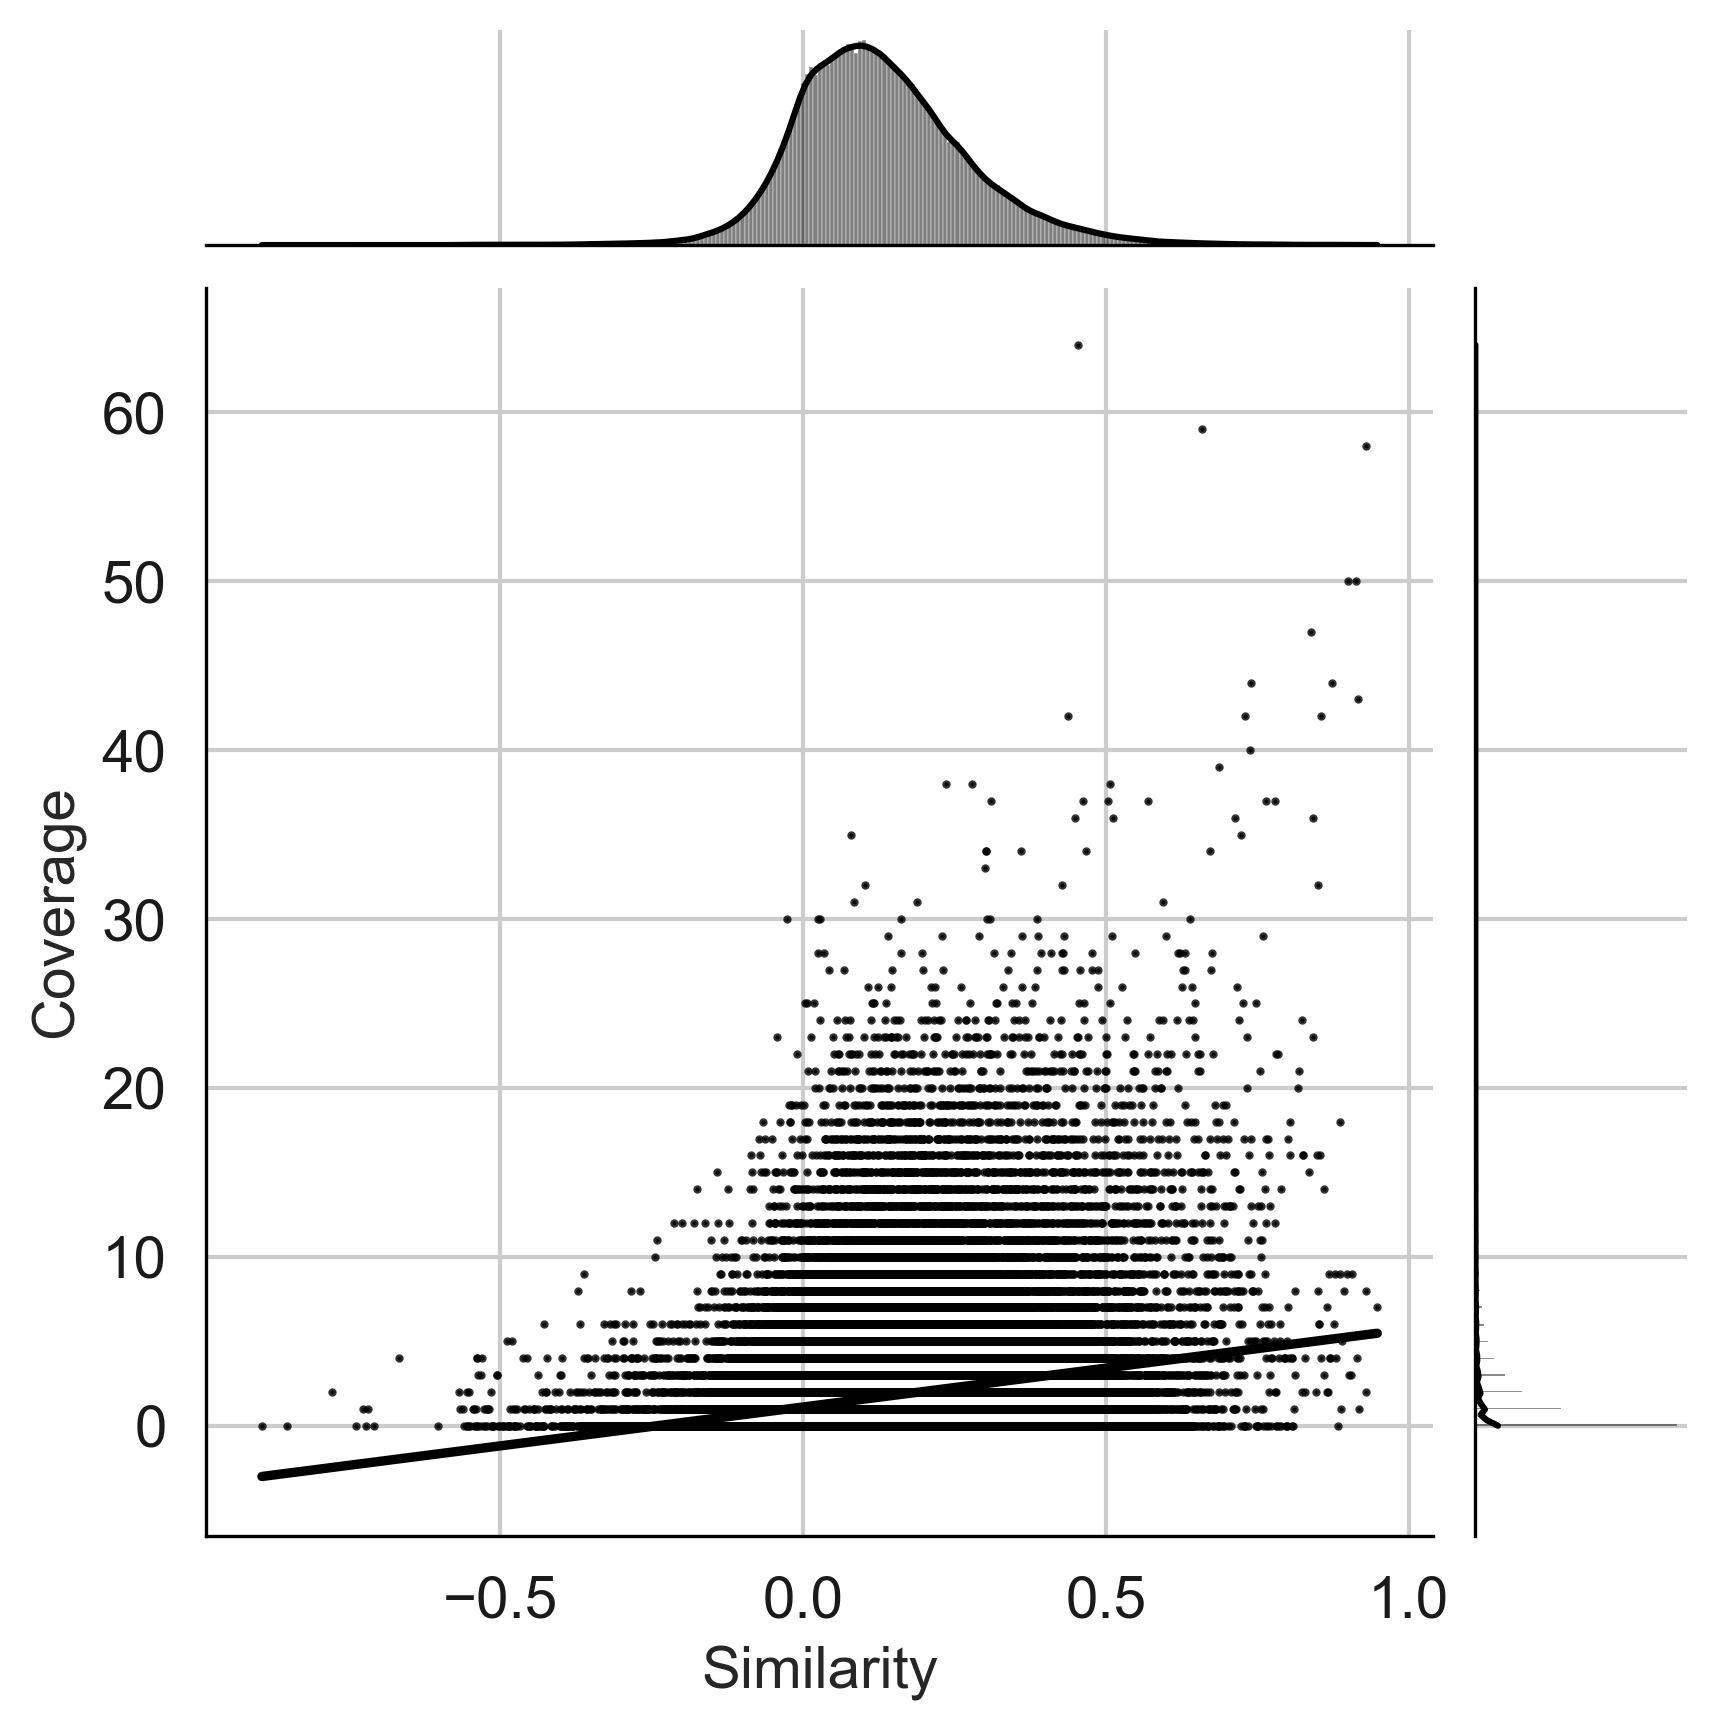

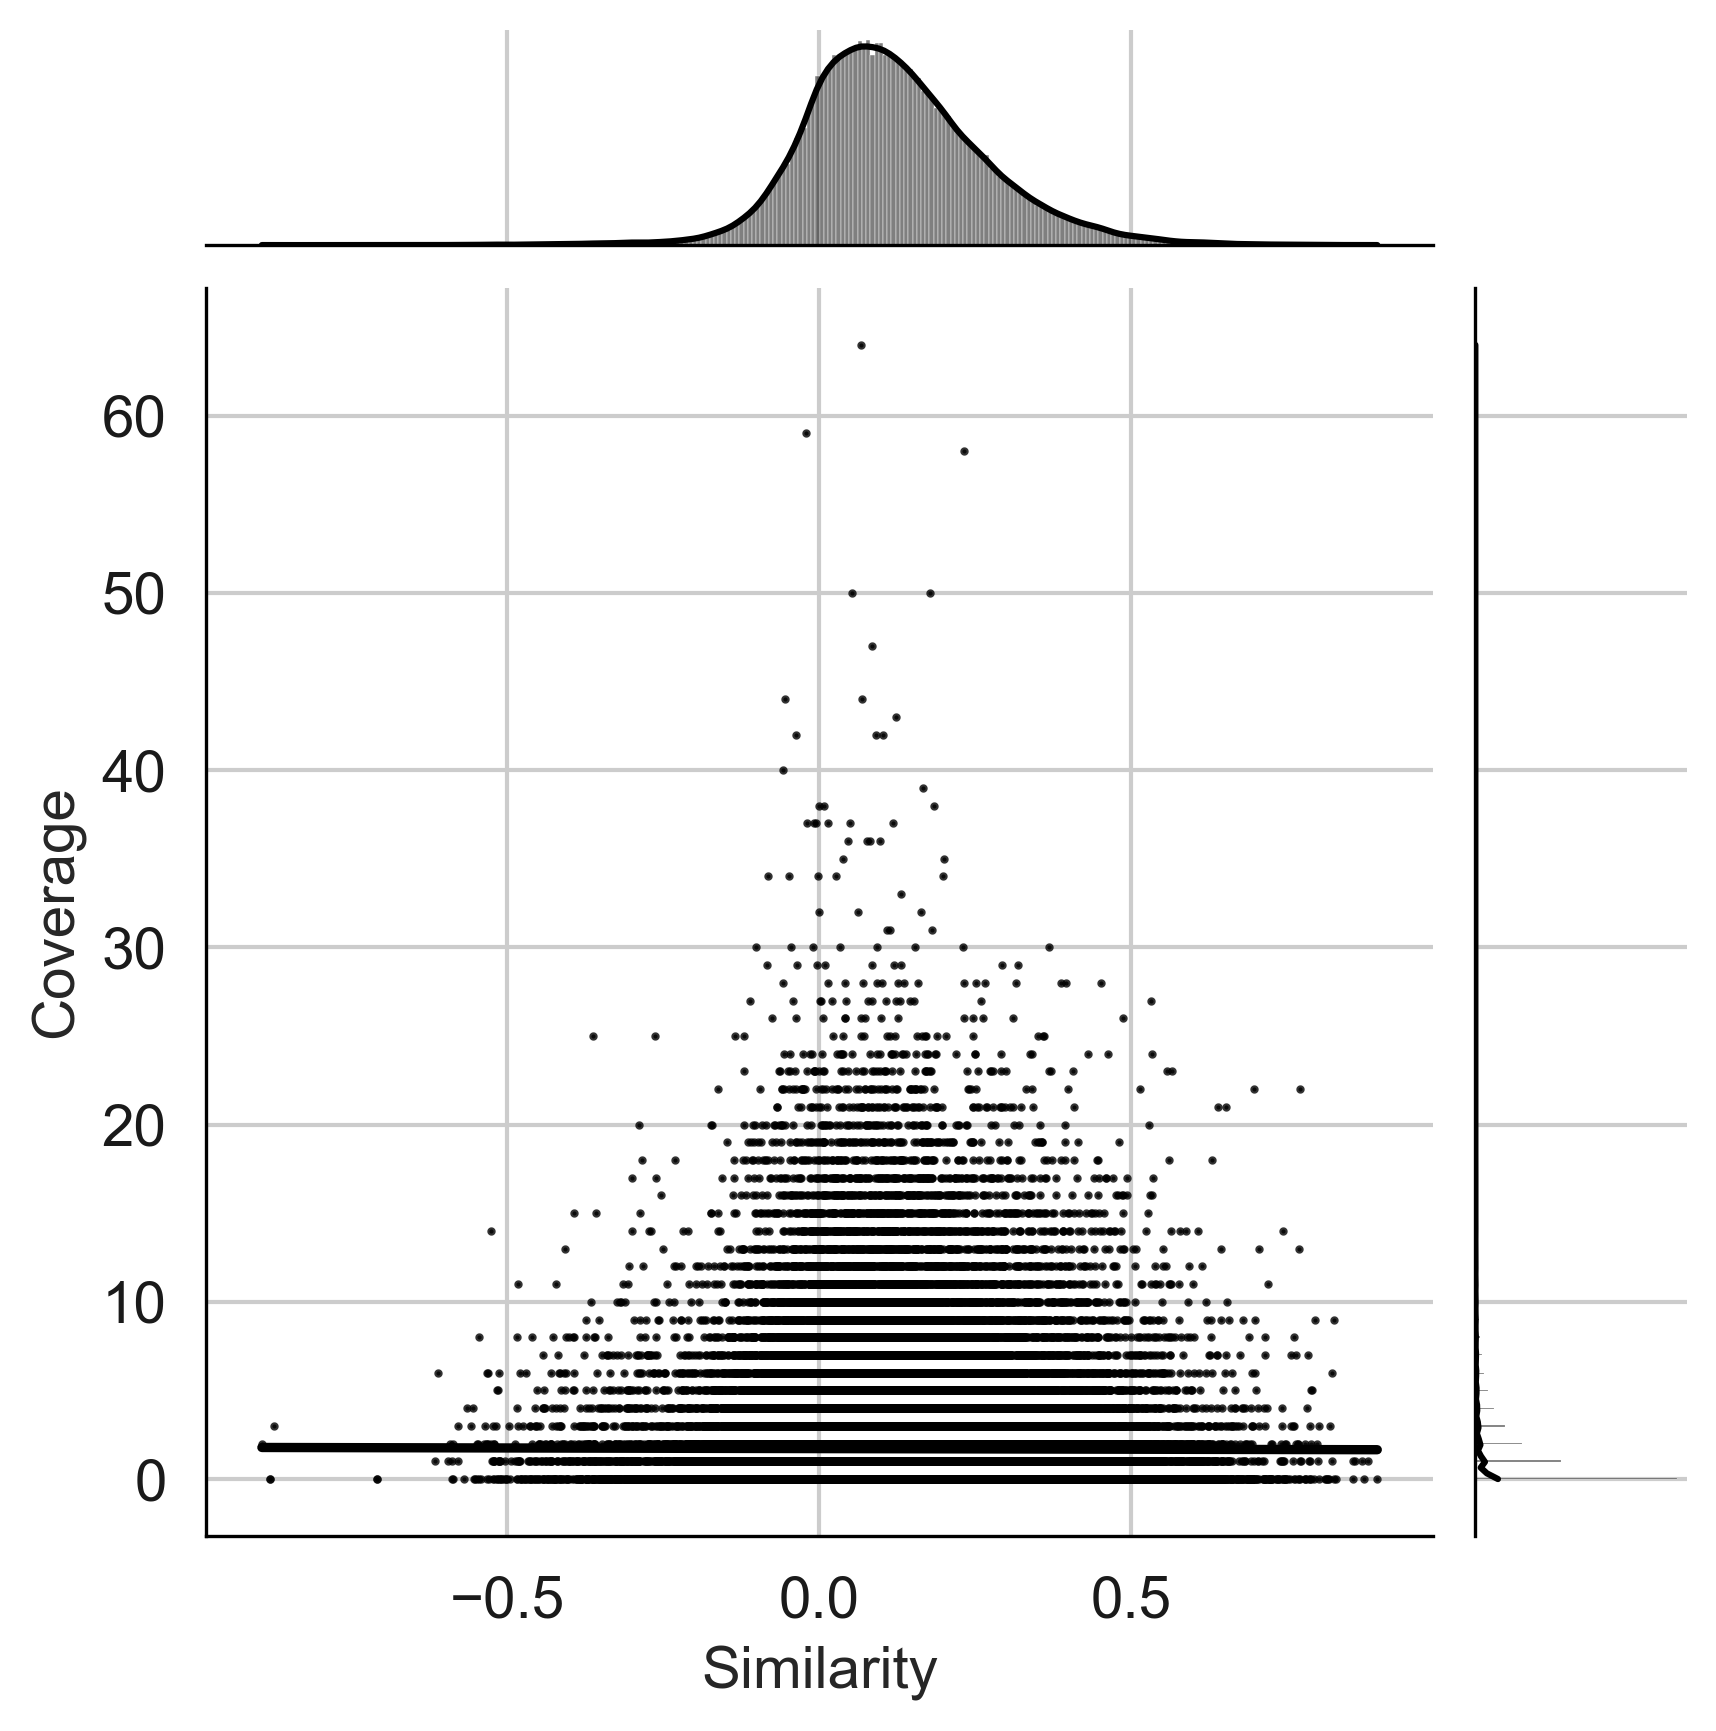

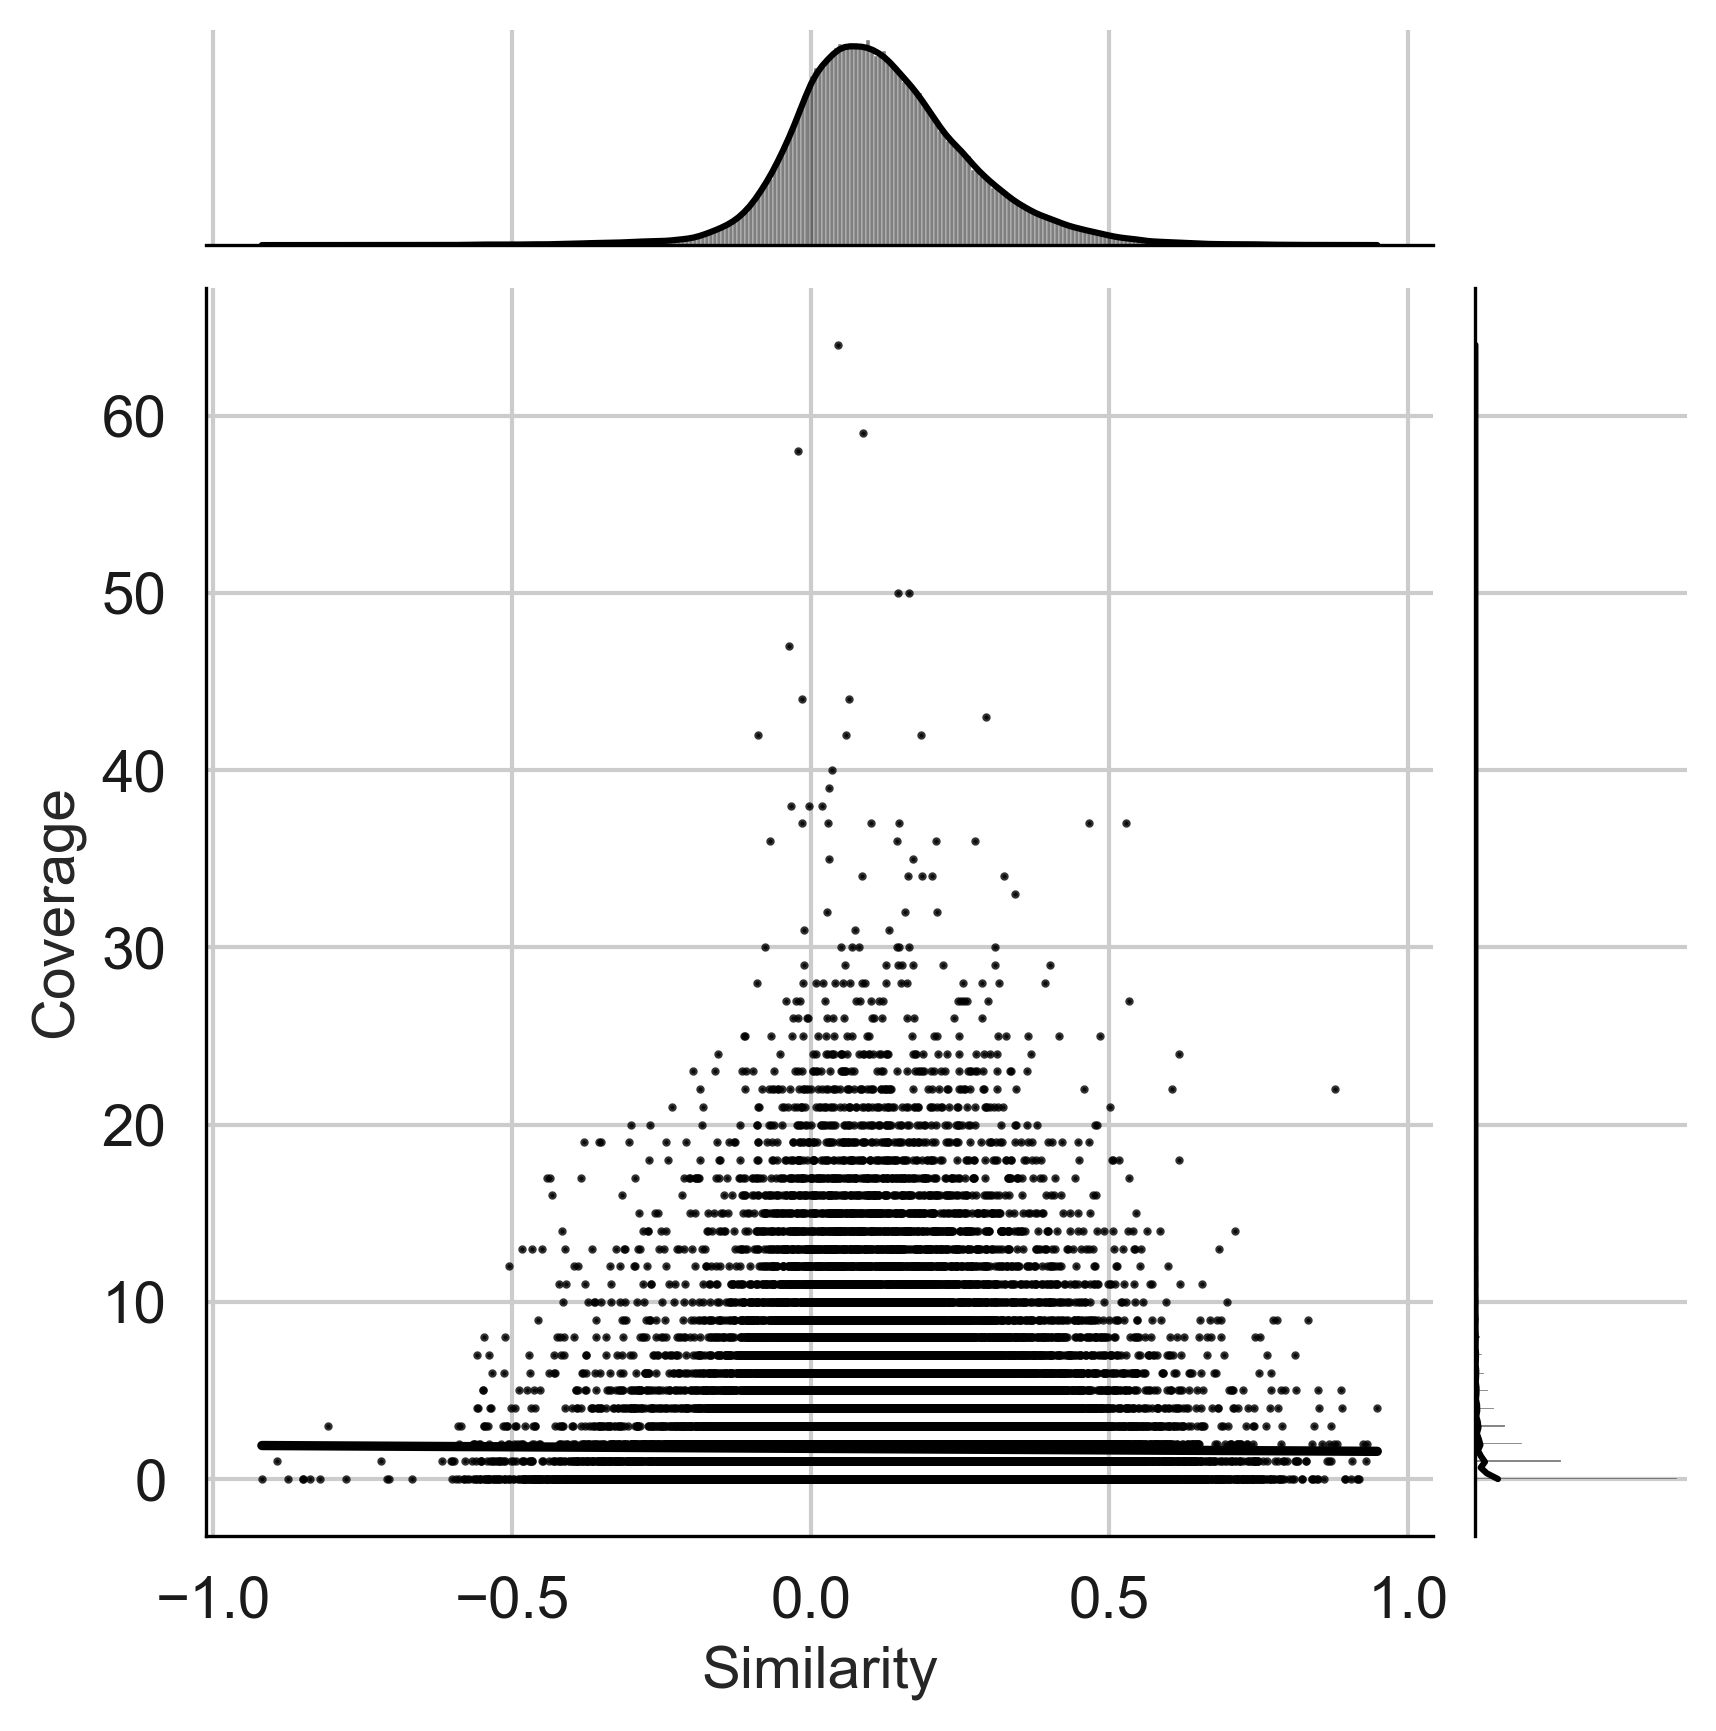

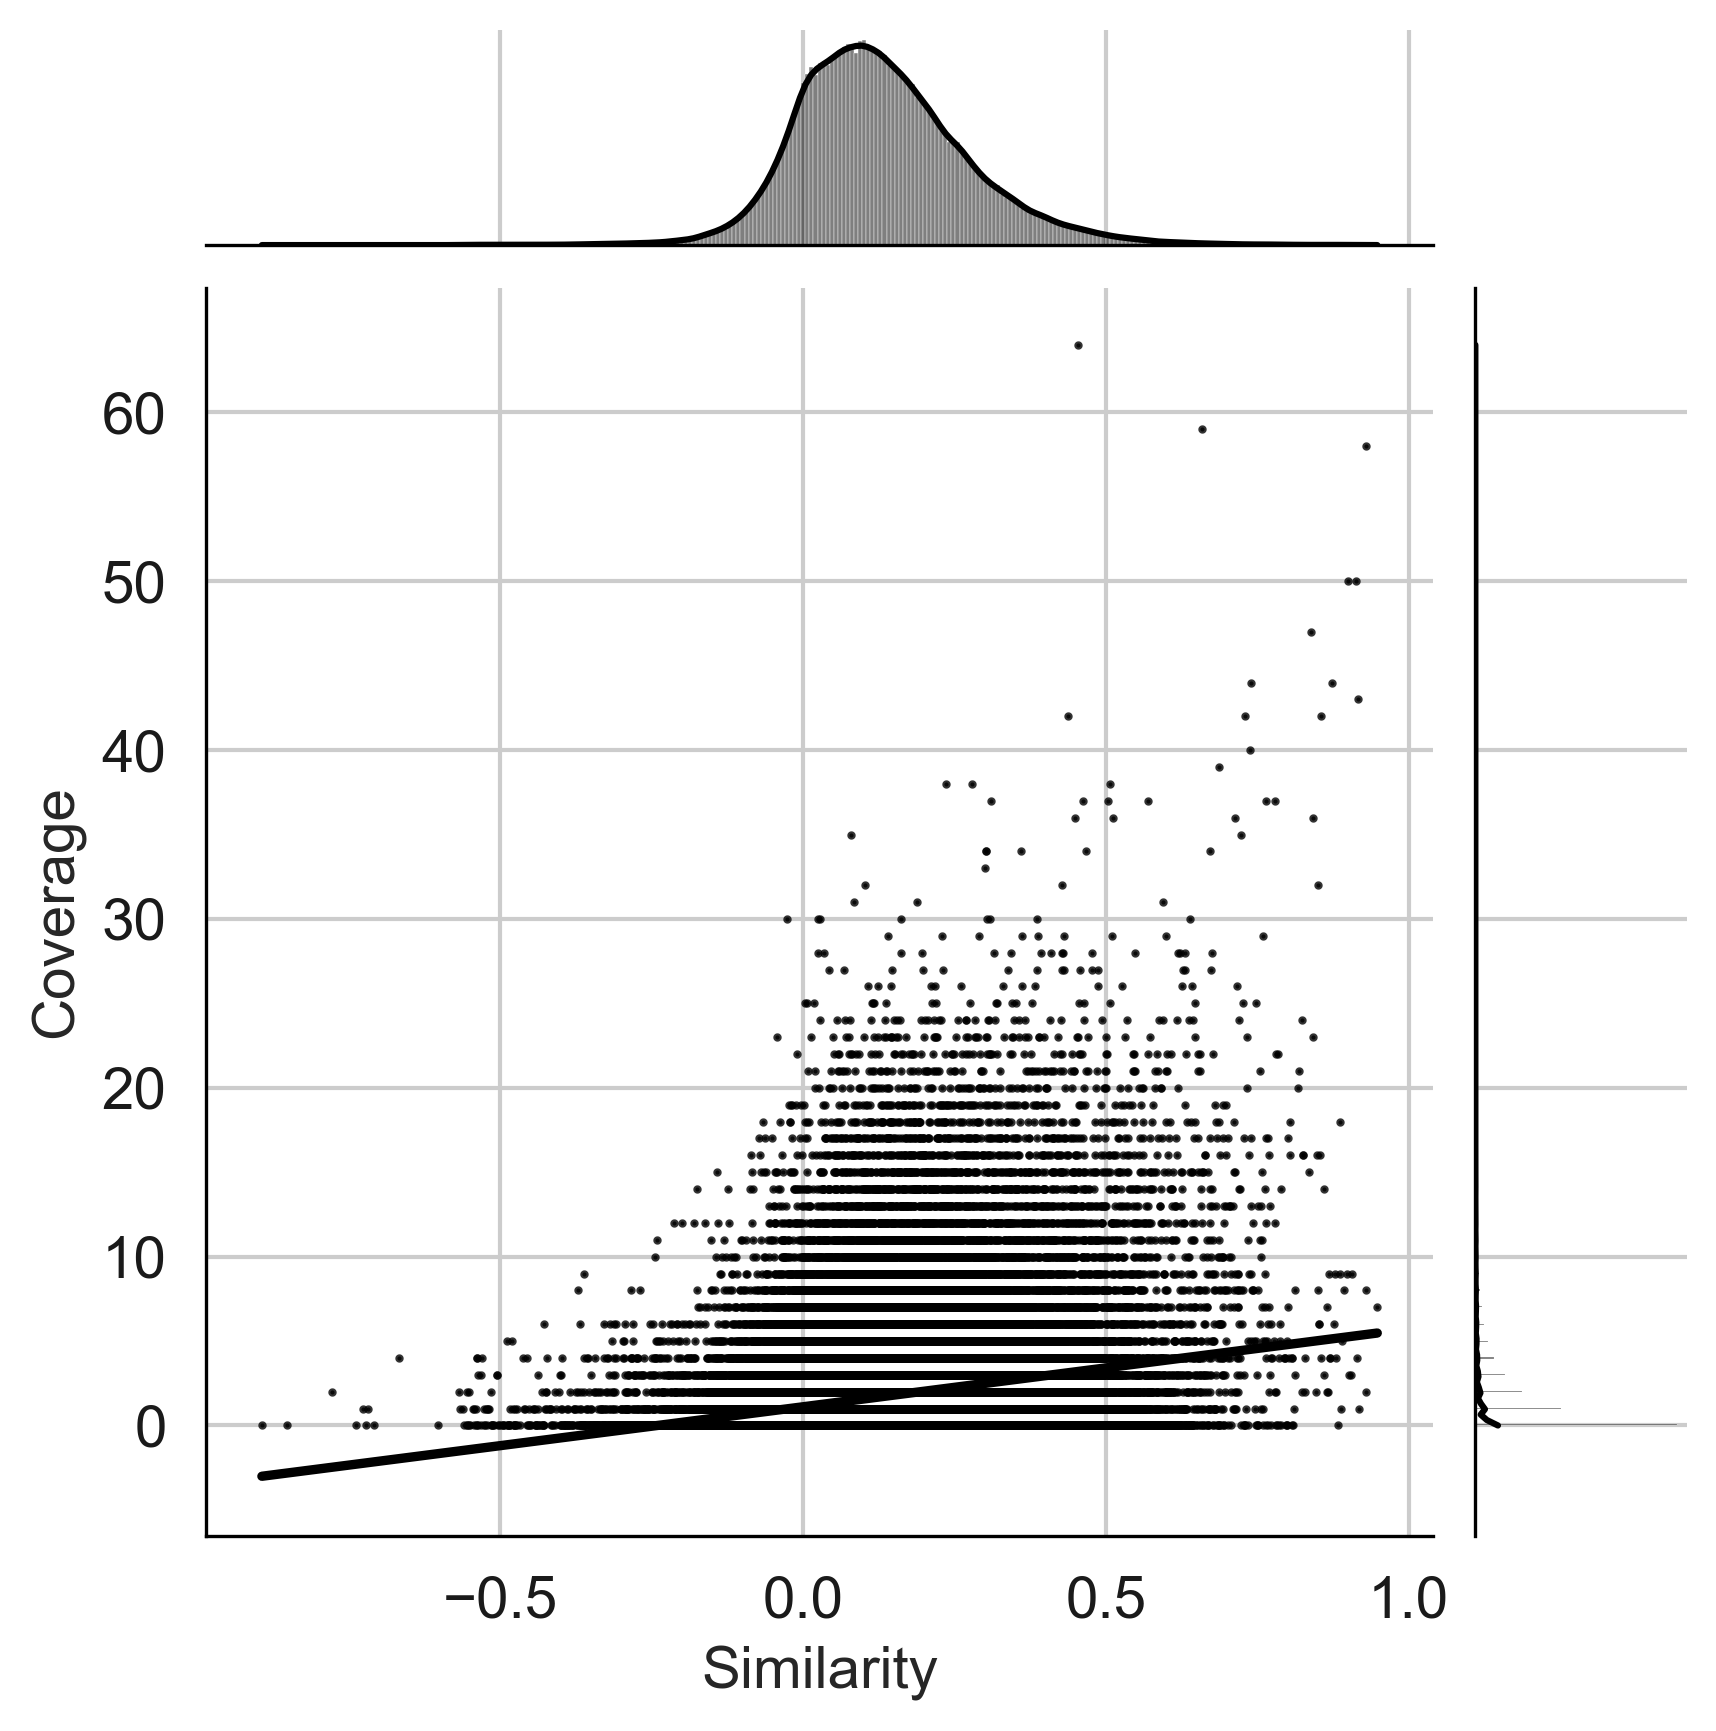

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

pair_sim = []
pair_path = []
pair_type = []
genes = []
import numpy
for pair in tqdm.tqdm(list(itertools.combinations(embed.genes,2))):
    if len(pathway_counts[pair[0]]) > 0 and len(pathway_counts[pair[1]]) > 0 and len(celltype_counts[pair[0]]) > 0 and len(celltype_counts[pair[1]]) > 0:
        pcov = pathway_coverage[pair[0]][pair[1]] + ct_coverage[pair[0]][pair[1]]
        pair_path.append(pcov)
        pair_sim.append(similarities[pair[0]][pair[1]])
        genes.append("{}-{}".format(pair[0],pair[1]))
        
dfcomb = pandas.DataFrame.from_dict({"Similarity":pair_sim,"Coverage":pair_path, "Genes":genes})
dfcomb1 = dfcomb
mn = numpy.mean(dfcomb["Similarity"])
md = numpy.median(dfcomb["Similarity"])
import seaborn as sns
import matplotlib.pyplot as plt

g1 = sns.jointplot(data=dfcomb,x="Similarity",y="Coverage",color="#000000",kind="reg",scatter_kws={'s':1})


pair_sim = []
pair_path = []
pair_type = []
genes = []
for pair in tqdm.tqdm(list(itertools.combinations(embed.genes,2))):
    if len(pathway_counts[pair[0]]) > 0 and len(pathway_counts[pair[1]]) > 0 and len(celltype_counts[pair[0]]) > 0 and len(celltype_counts[pair[1]]) > 0:
        if rsimilarities[pair[0]][pair[1]] >= .9: 
            continue
        pcov = pathway_coverage[pair[0]][pair[1]] + ct_coverage[pair[0]][pair[1]]
        pair_path.append(pcov)
        pair_sim.append(rsimilarities[pair[0]][pair[1]])
        genes.append("{}-{}".format(pair[0],pair[1]))
        
    
        
dfcomb = pandas.DataFrame.from_dict({"Similarity":pair_sim,"Coverage":pair_path, "Genes":genes})
dfcomb2 = dfcomb
mn = numpy.mean(dfcomb["Similarity"])
md = numpy.median(dfcomb["Similarity"])


g0 = sns.jointplot(data=dfcomb,x="Similarity",y="Coverage",color="#000000",kind="reg",scatter_kws={'s':1})


import pickle
rsimmi = pickle.load(open("references/rsim_mi.pkl","rb"))
pair_sim = []
pair_path = []
pair_type = []
genes = []
for pair in tqdm.tqdm(list(itertools.combinations(embed.genes,2))):
    if len(pathway_counts[pair[0]]) > 0 and len(pathway_counts[pair[1]]) > 0 and len(celltype_counts[pair[0]]) > 0 and len(celltype_counts[pair[1]]) > 0:
        pcov = pathway_coverage[pair[0]][pair[1]] + ct_coverage[pair[0]][pair[1]]
        pair_path.append(pcov)
        pair_sim.append(rsimmi[pair[0]][pair[1]])
        genes.append("{}-{}".format(pair[0],pair[1]))
        
dfcomb = pandas.DataFrame.from_dict({"Similarity":pair_sim,"Coverage":pair_path, "Genes":genes})
dfcomb4 = dfcomb
mn = numpy.mean(dfcomb["Similarity"])
md = numpy.median(dfcomb["Similarity"])


g2 = sns.jointplot(data=dfcomb,x="Similarity",y="Coverage",color="#000000",kind="reg",scatter_kws={'s':1})



dfcomb = pandas.read_csv("references/dfcomb.csv")
dfcomb3 = dfcomb
mn = numpy.mean(dfcomb["Similarity"])
md = numpy.median(dfcomb["Similarity"])

g3 = sns.jointplot(data=dfcomb,x="Similarity",y="Coverage",color="#000000",kind="reg",scatter_kws={'s':1})


# Run LDVAE for Comparison

In [52]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi

%matplotlib inline

Global seed set to 0
/Users/ceglian/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [53]:
adata = sc.read("PBMC.h5ad")
adata

AnnData object with n_obs × n_vars = 14039 × 1000
    obs: 'batch', 'log_counts', 'n_counts', 'n_genes', 'sample', 'celltype', 'detailed_celltype'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ceglian/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 250/250: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:53<00:00,  1.17s/it, loss=258, v_num=1]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:53<00:00,  1.17s/it, loss=258, v_num=1]
Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	KRT81, -2.7	KRT86, -2.6	LINC00176, -2.3	HOPX, -2.2	CXCR3, -2.1
	...
	IL27, 1.6	CCNA1, 1.8	CXCL11, 1.9	CXCL10, 2.0	CCL8, 2.1
---------------------------------------------------------------------------------------

Z_1:	RNASE1, -1.3	SDS, -1.3	AKR1C1, -1.2	PRKCDBP, -1.1	MMP19, -1.1
	...
	EDN1, 1.2	CLEC1B, 1.3	PPP1R17, 1.4	LYPD2, 1.4	MEG3, 1.5
---------------------------------------------------------------------------------------

Z_2:	CCL4, -1.4	CYTL1, -1.4	PTGDS, -1.2	CCL3, -1.2	LILRA4, -1.1
	...
	VPREB3, 0.86	CCR9, 0.88	PRELID2, 0.9	KRT1, 0.94	APBB2, 1.1
---------------------------------------------------

/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


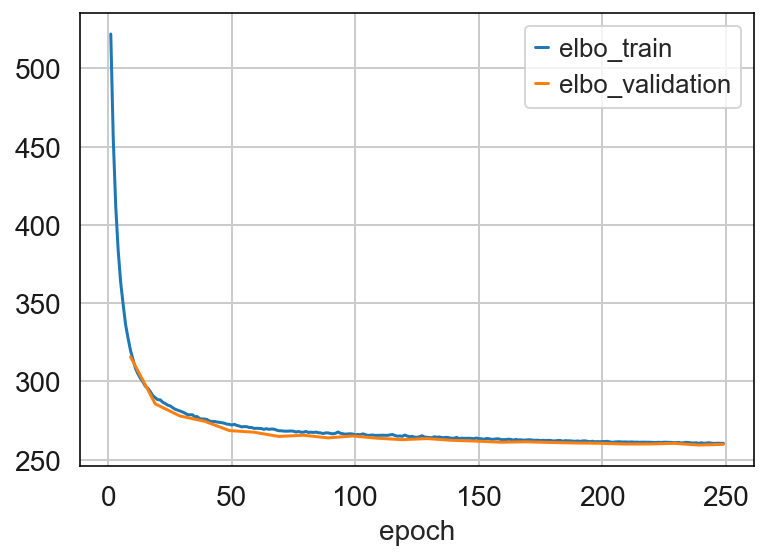

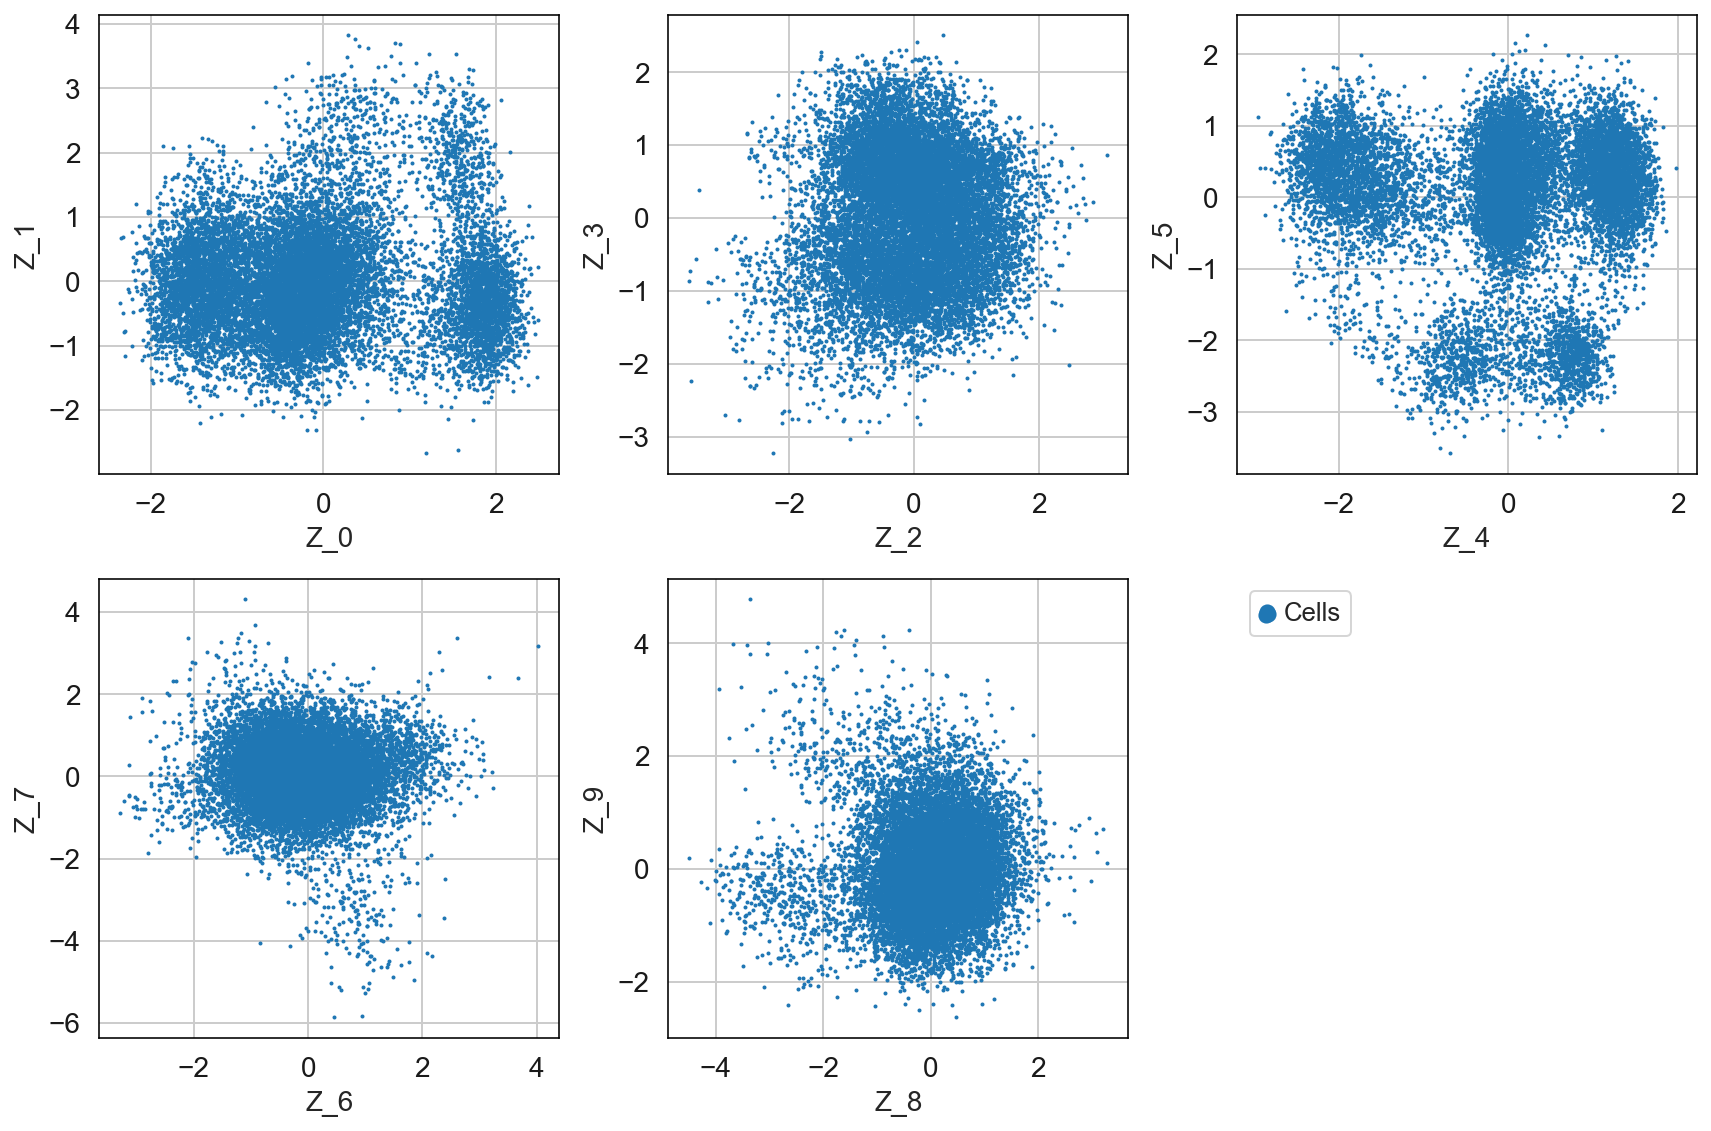

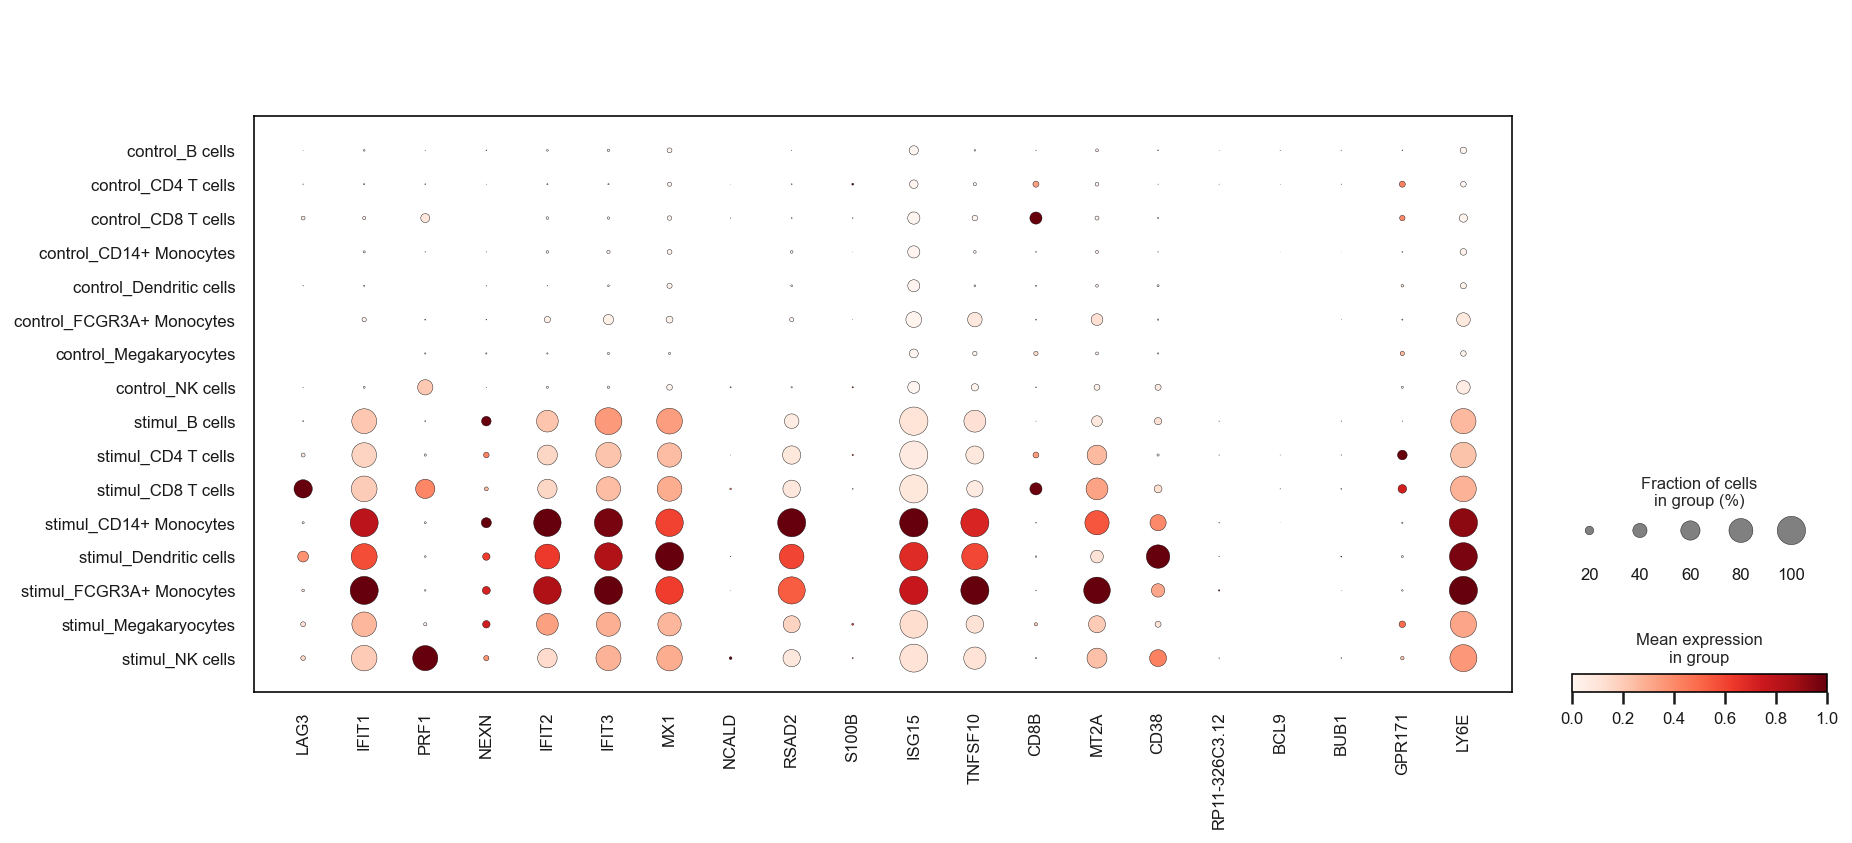

In [54]:
scvi.model.LinearSCVI.setup_anndata(adata)
model = scvi.model.LinearSCVI(adata, n_latent=10)
model.train(max_epochs=250, plan_kwargs={'lr':5e-3}, check_val_every_n_epoch=10)
train_elbo = model.history['elbo_train'][1:]
test_elbo = model.history['elbo_validation']
ax = train_elbo.plot()
test_elbo.plot(ax = ax)
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f'Z_{i}'] = z
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', s=4, label='Cells')

    plt.xlabel(f'Z_{f}')
    plt.ylabel(f'Z_{f + 1}')

plt.subplot(2, 3, 6)
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', label='Cells', s=4)
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], c='w', label=None)
plt.gca().set_frame_on(False)
plt.gca().axis('off')

lgd = plt.legend(scatterpoints=3, loc='upper left')
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()
loadings = model.get_loadings()
loadings.head()
print('Top loadings by magnitude\n---------------------------------------------------------------------------------------')
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ':\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.head(5).index])
    fstr += '\n\t...\n\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.tail(5).index])
    print(fstr + '\n---------------------------------------------------------------------------------------\n')
    

z4 = list(reversed(loadings["Z_4"].sort_values().tail(20).index.tolist()))
fig,ax = plt.subplots(1,1,figsize=(14,6))
sc.pl.dotplot(adata,z4,groupby="detailed_celltype",standard_scale="var",save="ldvae.pdf",ax=ax)
